In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# IMPORT LIBRARIES
# 📦 Import principali librerie
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 📦 Scikit-learn per modellazione e metriche
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, confusion_matrix, classification_report, 
    precision_recall_curve, average_precision_score
)

# 📦 Scikit-learn per modelli di classificazione
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, VotingClassifier, 
    StackingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.inspection import permutation_importance

# 📦 XGBoost
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor

# 📦 TensorFlow per modelli di rete neurale
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 📦 IPython Widgets (per interfacce interattive)
import ipywidgets as widgets
from ipywidgets import Layout
from IPython.display import display, clear_output

# 📊 Tabulate per visualizzare tabelle
from tabulate import tabulate

import requests
import io
from pyexcel_xls import get_data 

In [3]:
# 1) Scarica il .xls da GitHub
url = "https://raw.githubusercontent.com/aporrini/Financial-Product-Recommender/main/Dataset2_Needs.xls"
xls_bytes = requests.get(url).content

# 2) Carica tutto in memoria con pyexcel-xls
workbook = get_data(io.BytesIO(xls_bytes))

# 3) Trasforma i fogli “Needs” e “Products” in DataFrame
needs_df = pd.DataFrame(workbook['Needs'][1:],    columns=workbook['Needs'][0])
products_df = pd.DataFrame(workbook['Products'][1:], columns=workbook['Products'][0])

# 4) Metadata sheet: trova la prima riga con >=2 celle e usala come header
meta_rows = workbook['Metadata']
header_idx = next(i for i, row in enumerate(meta_rows) if len(row) > 1)
meta_header = meta_rows[header_idx]
meta_data   = meta_rows[header_idx+1:]

# Crea il DataFrame e rinomina esplicitamente le prime due colonne
metadata_df = pd.DataFrame(meta_data, columns=meta_header)
# Assicuriamoci che ci siano queste due colonne, qualunque sia il loro nome originario:
metadata_df = metadata_df.rename(
    columns={
        metadata_df.columns[0]: 'Metadata',
        metadata_df.columns[1]: 'Unnamed: 1'
    }
)

# 5) Cleanup (ad esempio, togli 'ID' da needs_df)
if 'ID' in needs_df.columns:
    needs_df = needs_df.drop(columns='ID')

# 6) Verifica veloce
print(needs_df.shape, products_df.shape, metadata_df.shape)


(5000, 9) (11, 3) (27, 2)


In [4]:
def create_variable_summary(df, metadata_df):
    # Create empty lists to store the chosen statistics
    stats_dict = {
        'Variable': [],
        'Description': [],
        'Mean': [],
        'Std': [],
        'Missing': [],
        'Min': [],
        'Max': []
    }

    # Create a metadata dictionary for easy lookup
    meta_dict = dict(zip(metadata_df['Metadata'], metadata_df['Unnamed: 1']))

    for col in df.columns:
        stats_dict['Variable'].append(col)
        stats_dict['Description'].append(meta_dict.get(col, 'N/A'))

        # Calculate some statistics for each column
        if pd.api.types.is_numeric_dtype(df[col]):
            stats_dict['Mean'].append(f"{df[col].mean():.2f}")
            stats_dict['Std'].append(f"{df[col].std():.2f}")
            stats_dict['Min'].append(f"{df[col].min():.2f}")
            stats_dict['Max'].append(f"{df[col].max():.2f}")
        else:
            stats_dict['Mean'].append('N/A')
            stats_dict['Std'].append('N/A')
            stats_dict['Min'].append('N/A')
            stats_dict['Max'].append('N/A')

        stats_dict['Missing'].append(df[col].isna().sum())

    return pd.DataFrame(stats_dict)


# Create summary tables
print("NEEDS VARIABLES SUMMARY:")
needs_summary = create_variable_summary(needs_df, metadata_df)
display(needs_summary.style
        .set_properties(**{'text-align': 'left'})
        .hide(axis='index'))

print("\nPRODUCTS VARIABLES SUMMARY:")
products_summary = create_variable_summary(products_df, metadata_df)
display(products_summary.style
        .set_properties(**{'text-align': 'left'})
        .hide(axis='index'))


NEEDS VARIABLES SUMMARY:


Variable,Description,Mean,Std,Missing,Min,Max
Age,"Age, in years",55.25,11.97,0,18.00,97.00
Gender,"Gender (Female = 1, Male = 0)",0.49,0.50,0,0.00,1.00
FamilyMembers,Number of components,2.51,0.76,0,1.00,5.00
FinancialEducation,Normalized level of Financial Education (estimate),0.42,0.15,0,0.04,0.90
RiskPropensity,Normalized Risk propensity from MIFID profile,0.36,0.15,0,0.02,0.88
Income,Income (thousands of euros); estimate,62.99,44.36,0,1.54,365.32
Wealth,Wealth (thousands of euros); sum of investments and cash accounts,93.81,105.47,0,1.06,2233.23
IncomeInvestment,Boolean variable for Income investment; 1 = High propensity,0.38,0.49,0,0.00,1.00
AccumulationInvestment,Boolean variable for Accumulation/growth investment; 1 = High propensity,0.51,0.50,0,0.00,1.00



PRODUCTS VARIABLES SUMMARY:


Variable,Description,Mean,Std,Missing,Min,Max
IDProduct,Product description,6.00,3.32,0,1.00,11.00
Type,"1 = Accumulation product, 0 = Income product",0.64,0.50,0,0.00,1.00
Risk,Normalized Synthetic Risk Indicator,0.43,0.24,0,0.12,0.88


In [5]:
# Step 1: Feature engineering and transformation function
def prepare_features(df):
    X = df.copy()

    # Log transformation for Wealth and Income
    X['Wealth_log'] = np.log1p(X['Wealth'])
    X['Income_log'] = np.log1p(X['Income '])

    # Feature engineering
def prepare_features(df):
    X = df.copy()
    X['Wealth_log'] = np.log1p(X['Wealth'])
    X['Income_log'] = np.log1p(X['Income '])
    X['Income_Wealth_Ratio'] = X['Income '] / X['Wealth'].replace(0, np.nan)
    X['Income_Wealth_Ratio_log'] = np.log1p(X['Income_Wealth_Ratio'].fillna(X['Income '].max()))
    X['Is_Single'] = (X['FamilyMembers'] == 1).astype(int)
    X['Is_Senior'] = (X['Age'] > 65).astype(int)
    X['Has_Education'] = (X['FinancialEducation'] > 0).astype(int)
    X['Risk_Age_Interaction'] = X['RiskPropensity'] * X['Age']

    features_base = ['Age', 'Gender', 'FamilyMembers', 'FinancialEducation',
                     'RiskPropensity', 'Wealth_log', 'Income_log']

    features_engineered = features_base + [
        'Income_Wealth_Ratio_log',
        'Is_Single',
        'Is_Senior',
        'Has_Education',
        'Risk_Age_Interaction'
    ]

    scaler = MinMaxScaler()
    X_base = pd.DataFrame(scaler.fit_transform(X[features_base]), columns=features_base)
    X_engineered = pd.DataFrame(scaler.fit_transform(X[features_engineered]), columns=features_engineered)

    return X_base, X_engineered

# Step 2: Data split function
def split_data(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    return X_train, X_test, y_train, y_test

# Step 3: Model training and evaluation function
def train_evaluate_model(X_train, y_train, X_test, y_test, model, k_folds=5):
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    cv_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': []
    }

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_train_fold, y_train_fold)
        y_val_pred = model.predict(X_val_fold)

        cv_metrics['accuracy'].append(accuracy_score(y_val_fold, y_val_pred))
        cv_metrics['precision'].append(precision_score(y_val_fold, y_val_pred))
        cv_metrics['recall'].append(recall_score(y_val_fold, y_val_pred))
        cv_metrics['f1'].append(f1_score(y_val_fold, y_val_pred))

    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)

    return {
        'cv_metrics': {
            metric: {
                'mean': np.mean(scores),
                'std': np.std(scores)
            } for metric, scores in cv_metrics.items()
        },
        'test_metrics': {
            'accuracy': accuracy_score(y_test, y_test_pred),
            'precision': precision_score(y_test, y_test_pred),
            'recall': recall_score(y_test, y_test_pred),
            'f1': f1_score(y_test, y_test_pred)
        }
    }

# Step 4: Display results function
def display_results_table(results_dict, model_name, feature_type):
    cv_data = {
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1'],
        'CV Mean': [
            results_dict['cv_metrics']['accuracy']['mean'],
            results_dict['cv_metrics']['precision']['mean'],
            results_dict['cv_metrics']['recall']['mean'],
            results_dict['cv_metrics']['f1']['mean']
        ],
        'CV Std': [
            results_dict['cv_metrics']['accuracy']['std'],
            results_dict['cv_metrics']['precision']['std'],
            results_dict['cv_metrics']['recall']['std'],
            results_dict['cv_metrics']['f1']['std']
        ],
        'Test Set': [
            results_dict['test_metrics']['accuracy'],
            results_dict['test_metrics']['precision'],
            results_dict['test_metrics']['recall'],
            results_dict['test_metrics']['f1']
        ]
    }

    df = pd.DataFrame(cv_data)
    df = df.round(3)

    print(f"\n{model_name} - {feature_type}")
    print("=" * 60)
    print(tabulate(df, headers='keys', tablefmt='pretty'))


In [6]:
# Step 5: Run full analysis
# Prepare features
X_base, X_engineered = prepare_features(needs_df)
y_income = needs_df['IncomeInvestment']
y_accum = needs_df['AccumulationInvestment']

# Define models
models = {
    'SVM': SVC(),
    'NaiveBayes': GaussianNB(),
    'DecisionTree': DecisionTreeClassifier(random_state=42)
}

# Actually run analysis and display results
for target_name, y in [('Income Investment', y_income), ('Accumulation Investment', y_accum)]:
    print(f"\nTarget Variable: {target_name}")
    print("=" * 80)

    X_base_train, X_base_test, y_train, y_test = split_data(X_base, y)
    X_eng_train, X_eng_test, _, _ = split_data(X_engineered, y)

    for model_name, model in models.items():
        results_base = train_evaluate_model(X_base_train, y_train, X_base_test, y_test, model)
        display_results_table(results_base, model_name, "Base Features")

        results_eng = train_evaluate_model(X_eng_train, y_train, X_eng_test, y_test, model)
        display_results_table(results_eng, model_name, "Engineered Features")


Target Variable: Income Investment

SVM - Base Features
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-----------+---------+--------+----------+
| 0 | Accuracy  |  0.771  | 0.015  |  0.747   |
| 1 | Precision |  0.816  | 0.011  |  0.796   |
| 2 |  Recall   |  0.521  |  0.04  |  0.458   |
| 3 |    F1     |  0.635  | 0.027  |  0.582   |
+---+-----------+---------+--------+----------+

SVM - Engineered Features
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-----------+---------+--------+----------+
| 0 | Accuracy  |  0.742  | 0.013  |  0.724   |
| 1 | Precision |  0.826  | 0.011  |  0.781   |
| 2 |  Recall   |  0.416  | 0.029  |  0.391   |
| 3 |    F1     |  0.553  | 0.025  |  0.521   |
+---+-----------+---------+--------+----------+

NaiveBayes - Base Features
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-----------+-------

In [7]:
# --- Feature Engineering Avanzato ---
def prepare_features_advanced(df):
    X = df.copy()
    X.columns = X.columns.str.strip()

    X['Wealth_log'] = np.log1p(X['Wealth'])
    X['Income_log'] = np.log1p(X['Income'])
    X['Income_Wealth_Ratio'] = X['Income'] / X['Wealth'].replace(0, np.nan)
    X['Income_Wealth_Ratio_log'] = np.log1p(X['Income_Wealth_Ratio'].fillna(X['Income'].max()))
    X['Is_Single'] = (X['FamilyMembers'] == 1).astype(int)
    X['Is_Senior'] = (X['Age'] > 65).astype(int)
    X['Has_Education'] = (X['FinancialEducation'] > 0).astype(int)
    X['Risk_Age_Interaction'] = X['RiskPropensity'] * X['Age']

    features_base = ['Age', 'Gender', 'FamilyMembers', 'FinancialEducation',
                     'RiskPropensity', 'Wealth_log', 'Income_log']

    features_engineered = features_base + [
        'Income_Wealth_Ratio_log',
        'Is_Single',
        'Is_Senior',
        'Has_Education',
        'Risk_Age_Interaction'
    ]

    scaler = MinMaxScaler()
    X_base = pd.DataFrame(scaler.fit_transform(X[features_base]), columns=features_base)
    X_engineered = pd.DataFrame(scaler.fit_transform(X[features_engineered]), columns=features_engineered)

    return X_base, X_engineered

# --- Prepara features ---
X_base, X_engineered = prepare_features_advanced(needs_df)
y_income = needs_df['IncomeInvestment']
y_accum = needs_df['AccumulationInvestment']

# --- Definizione modelli ---
models = {
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False),
    'RandomForest': RandomForestClassifier(random_state=42)
}

# --- Esecuzione analisi completa ---
for target_name, y in [('Income Investment', y_income), ('Accumulation Investment', y_accum)]:
    print(f"\n📈 Target Variable: {target_name}")
    print("=" * 90)

    X_base_train, X_base_test, y_train, y_test = split_data(X_base, y)
    X_eng_train, X_eng_test, _, _ = split_data(X_engineered, y)

    for model_name, model in models.items():
        results_base = train_evaluate_model(X_base_train, y_train, X_base_test, y_test, model)
        display_results_table(results_base, model_name, "Base Features")

        results_eng = train_evaluate_model(X_eng_train, y_train, X_eng_test, y_test, model)
        display_results_table(results_eng, model_name, "Engineered Features")



📈 Target Variable: Income Investment

XGBoost - Base Features
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-----------+---------+--------+----------+
| 0 | Accuracy  |  0.792  | 0.015  |  0.763   |
| 1 | Precision |  0.789  | 0.013  |  0.765   |
| 2 |  Recall   |  0.625  | 0.028  |  0.552   |
| 3 |    F1     |  0.697  | 0.021  |  0.641   |
+---+-----------+---------+--------+----------+

XGBoost - Engineered Features
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-----------+---------+--------+----------+
| 0 | Accuracy  |   0.8   | 0.016  |  0.769   |
| 1 | Precision |  0.809  | 0.016  |  0.782   |
| 2 |  Recall   |  0.627  | 0.031  |  0.552   |
| 3 |    F1     |  0.706  | 0.025  |  0.647   |
+---+-----------+---------+--------+----------+

RandomForest - Base Features
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-------

ALESSIO SI DIVERTE A FARE UN MODELLO X BATTERE CECIO

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6032 - loss: 0.6756 - val_accuracy: 0.6240 - val_loss: 0.6491
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6147 - loss: 0.6427 - val_accuracy: 0.6240 - val_loss: 0.6282
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6160 - loss: 0.6215 - val_accuracy: 0.7190 - val_loss: 0.6076
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7199 - loss: 0.5970 - val_accuracy: 0.7570 - val_loss: 0.5897
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7432 - loss: 0.5694 - val_accuracy: 0.7610 - val_loss: 0.5664
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7624 - loss: 0.5506 - val_accuracy: 0.7720 - val_loss: 0.5502
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7666 - loss: 0.5526 - val_accuracy: 0.7490 - val_loss: 0.5453
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7579 - loss: 0.5411 - val_accuracy: 0.7750 - val_loss:

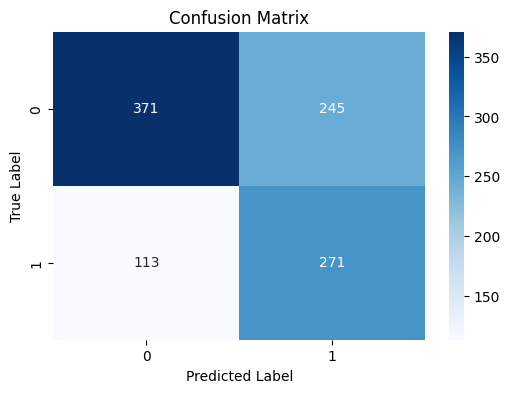

In [ ]:
"""

# Aggiungo qua le librerie così se poi fa schifo elimino

import tensorflow as tf
from tensorflow.keras import layers, models

# Queste penso già importate
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Dimensione input
size_features_input = 7
# Creo il modello sequential
model = models.Sequential([
    layers.Dense(32, activation='tanh', input_shape=(size_features_input, )),
    # layers.Dense(64, activation='sigmoid'), # peggiora risultati
    layers.Dense(16, activation='tanh'),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compilo il modello
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # ha senso accuracy perchè circa tutti uguali come numero (altrimenti AUC)

# Traino
""" 
Ricordo questi i nomi delle features
X_base, X_engineered = prepare_features_advanced(needs_df) # sono 7 e poi 12 input
y_income = needs_df['IncomeInvestment']
y_accum = needs_df['AccumulationInvestment']
"""
# Preparo dati

X_base_train, X_base_test, y_income_train, y_income_test = split_data(X_base, y_income)

model.fit(X_base_train, y_income_train, epochs = 10, batch_size=32, validation_split=0.25)

#valuto
y_pred = model.predict(X_base_test)

# Scelgo soglia

valori = np.linspace(0, 1, 51)
f1_best = 0
best = 0

for i in valori:

    y_pred_classes = [1 if y > i else 0 for y in y_pred]

    # Creazione della confusion matrix
    cm = confusion_matrix(y_income_test, y_pred_classes)

    # Calcolo delle metriche
    precision = precision_score(y_income_test, y_pred_classes)
    recall = recall_score(y_income_test, y_pred_classes)
    f1 = f1_score(y_income_test, y_pred_classes)

    if recall > 0.7 and f1 > f1_best:
        best = i
        f1_best = f1

y_pred_classes = [1 if y > best else 0 for y in y_pred]

# Creazione della confusion matrix
cm = confusion_matrix(y_income_test, y_pred_classes)

# Calcolo delle metriche
precision = precision_score(y_income_test, y_pred_classes)
recall = recall_score(y_income_test, y_pred_classes)
f1 = f1_score(y_income_test, y_pred_classes)
    


# Stampo i risultati
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

# Visualizzazione
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

"""


MI FACCIO FARE MODELLO X HYPERPARAMETER TUNING AUTOMATICO DA CHAT, INCOME

Trial 100 Complete [00h 00m 07s]
val_accuracy: 0.793749988079071

Best val_accuracy So Far: 0.800000011920929
Total elapsed time: 00h 19m 38s
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━

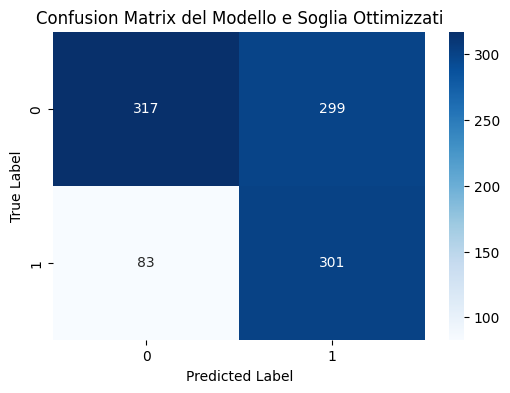

In [ ]:
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import keras_tuner as kt
from tensorflow.keras import layers, models

# Assicurati che size_features_input, X_base_train, X_base_test, y_income_train e y_income_test siano definiti

# 1. Funzione per costruire il modello
def build_model(hp):
    model = models.Sequential()
    model.add(layers.Input(shape=(size_features_input,)))
    
    # Numero variabile di layer nascosti
    for i in range(hp.Int('num_layers', 1, 5)):
        model.add(layers.Dense(
            units=hp.Int(f'units_{i}', min_value=8, max_value=128, step=16),
            activation=hp.Choice(f'activation_{i}', ['relu', 'tanh'])
        ))
    
    # Livello di output
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Compilazione del modello
    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


# 2. Istanziamento del tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=100,
    executions_per_trial=1,
    directory='my_dir',
    project_name='income_investment_tuning'
)

# 3. Ricerca iperparametri
tuner.search(X_base_train, y_income_train, epochs=20, validation_split=0.2)

# 4. Recupero dei migliori modelli
tuned_models = tuner.get_best_models(num_models=30)

# 5. Selezione del modello e soglia ottimali
best_model    = None
best_threshold= 0.5
best_f1       = 0.0
best_cm       = None
best_metrics  = None

thresholds = np.linspace(0, 1, 101)

for model in tuned_models:
    y_pred_prob = model.predict(X_base_test).ravel()
    # trova la miglior soglia per questo modello
    for thr in thresholds:
        y_pred_cls = (y_pred_prob > thr).astype(int)
        precision = precision_score(y_income_test, y_pred_cls, zero_division=0)
        recall    = recall_score(y_income_test, y_pred_cls, zero_division=0)
        f1        = f1_score(y_income_test, y_pred_cls, zero_division=0)
        # filtro recall > 0.75 e massimizza F1
        if recall > 0.75 and f1 > best_f1:
            best_f1        = f1
            best_model     = model
            best_threshold = thr
            best_cm        = confusion_matrix(y_income_test, y_pred_cls)
            best_metrics   = (precision, recall, f1)

# 6. Stampa dei risultati
if best_model is None:
    print("Nessun modello con recall > 0.75 trovato tra i top 10.")
else:
    precision, recall, f1 = best_metrics
    print(f"Soglia ottimale: {best_threshold:.2f}")
    print("Confusion Matrix:")
    print(best_cm)
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    plt.figure(figsize=(6, 4))
    sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix del Modello e Soglia Ottimizzati')
    plt.show()

"""

STESSA COSA MA X ACCUMULATION ORA

Reloading Tuner from my_dir\accumulation_investment_tuning\tuner0.json
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━

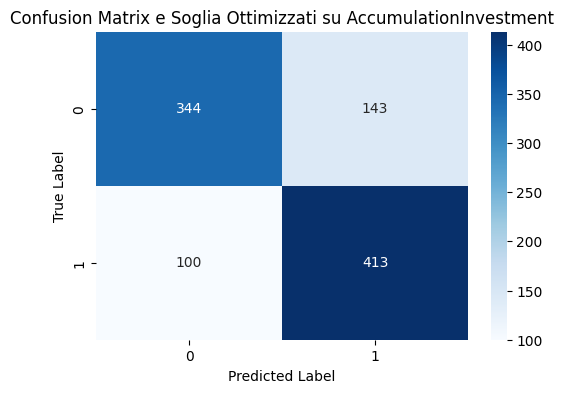

In [ ]:
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import keras_tuner as kt
from tensorflow.keras import layers, models

# Assicurati che size_features_input, X_base, X_engineered, y_accum (AccumulationInvestment) siano definiti
# e che la funzione split_data() sia disponibile

# Prepara i dati per AccumulationInvestment
X_base_train, X_base_test, y_accum_train, y_accum_test = split_data(X_base, y_accum)

# 1. Funzione per costruire il modello
def build_model(hp):
    model = models.Sequential()
    model.add(layers.Input(shape=(size_features_input,)))
    for i in range(hp.Int('num_layers', 1, 5)):
        model.add(layers.Dense(
            units=hp.Int(f'units_{i}', min_value=8, max_value=128, step=16),
            activation=hp.Choice(f'activation_{i}', ['relu', 'tanh'])
        ))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# 2. Istanziamento del tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=100,
    executions_per_trial=1,
    directory='my_dir',
    project_name='accumulation_investment_tuning'
)

# 3. Ricerca iperparametri
tuner.search(X_base_train, y_accum_train, epochs=20, validation_split=0.2)

# 4. Recupero dei migliori modelli
tuned_models = tuner.get_best_models(num_models=30)

# 5. Selezione del modello e soglia ottimali
best_model     = None
best_threshold = 0.5
best_f1        = 0.0
best_cm        = None
best_metrics   = None

thresholds = np.linspace(0, 1, 101)

for model in tuned_models:
    y_pred_prob = model.predict(X_base_test).ravel()
    for thr in thresholds:
        y_pred_cls = (y_pred_prob > thr).astype(int)
        precision = precision_score(y_accum_test, y_pred_cls, zero_division=0)
        recall    = recall_score(y_accum_test, y_pred_cls, zero_division=0)
        f1        = f1_score(y_accum_test, y_pred_cls, zero_division=0)
        if recall > 0.75 and f1 > best_f1:
            best_f1        = f1
            best_model     = model
            best_threshold = thr
            best_cm        = confusion_matrix(y_accum_test, y_pred_cls)
            best_metrics   = (precision, recall, f1)

# 6. Stampa dei risultati
if best_model is None:
    print("Nessun modello con recall > 0.75 trovato tra i top 30.")
else:
    precision, recall, f1 = best_metrics
    print(f"Soglia ottimale: {best_threshold:.2f}")
    print("Confusion Matrix:")
    print(best_cm)
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(model)
    plt.figure(figsize=(6, 4))
    sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix e Soglia Ottimizzati su AccumulationInvestment')
    plt.show()

"""


MULTI_OUTPUT CLASSIFIER

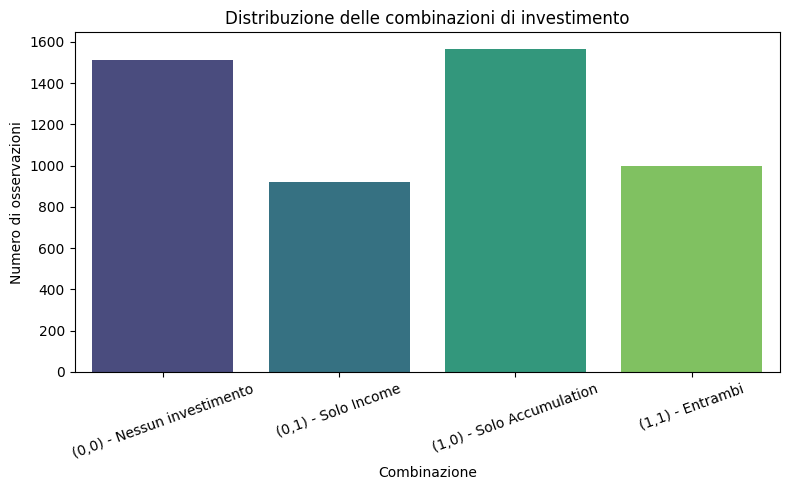

                         Label  Count
0  (0,0) - Nessun investimento   1514
1          (0,1) - Solo Income    920
2    (1,0) - Solo Accumulation   1568
3             (1,1) - Entrambi    998


In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Crea una colonna con la combinazione come stringa
needs_df['Combo'] = needs_df['AccumulationInvestment'].astype(str) + ',' + needs_df['IncomeInvestment'].astype(str)

# Conta le occorrenze
combo_counts = needs_df['Combo'].value_counts().sort_index()
combo_df = combo_counts.rename_axis('Combination').reset_index(name='Count')

# Mappa etichette leggibili
label_map = {
    '0,0': '(0,0) - Nessun investimento',
    '0,1': '(0,1) - Solo Income',
    '1,0': '(1,0) - Solo Accumulation',
    '1,1': '(1,1) - Entrambi'
}
combo_df['Label'] = combo_df['Combination'].map(label_map)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(data=combo_df, x='Label', y='Count', palette='viridis')
plt.title('Distribuzione delle combinazioni di investimento')
plt.xlabel('Combinazione')
plt.ylabel('Numero di osservazioni')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

# (Opzionale) stampa tabella
print(combo_df[['Label', 'Count']])


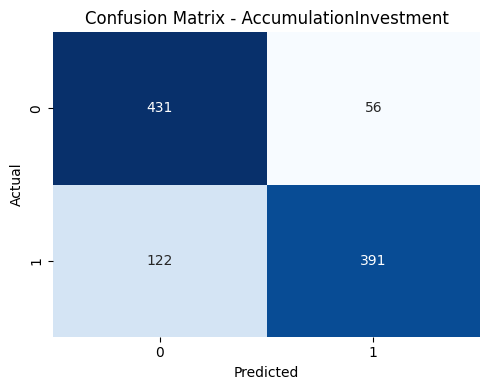

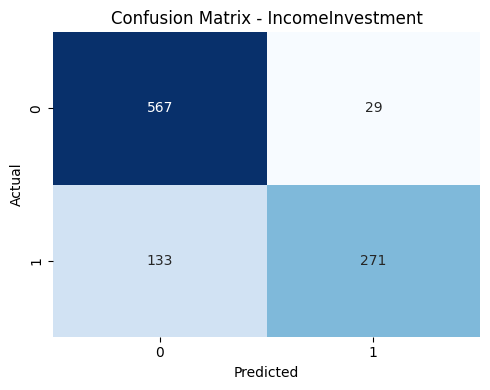


Test F1 Scores:
Accumulation F1: 0.815
Income F1: 0.770
Macro Avg F1: 0.792

Classification Reports:

AccumulationInvestment
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       487
           1       0.87      0.76      0.81       513

    accuracy                           0.82      1000
   macro avg       0.83      0.82      0.82      1000
weighted avg       0.83      0.82      0.82      1000


IncomeInvestment
              precision    recall  f1-score   support

           0       0.81      0.95      0.88       596
           1       0.90      0.67      0.77       404

    accuracy                           0.84      1000
   macro avg       0.86      0.81      0.82      1000
weighted avg       0.85      0.84      0.83      1000



In [9]:
# --- Funzione per il feature engineering (copiata dal tuo codice) ---
def prepare_features(df):
    X = df.copy()
    X['Wealth_log'] = np.log1p(X['Wealth'])
    X['Income_log'] = np.log1p(X['Income '])
    X['Income_Wealth_Ratio'] = X['Income '] / X['Wealth'].replace(0, np.nan)
    X['Income_Wealth_Ratio_log'] = np.log1p(X['Income_Wealth_Ratio'].fillna(X['Income '].max()))
    X['Is_Single'] = (X['FamilyMembers'] == 1).astype(int)
    X['Is_Senior'] = (X['Age'] > 65).astype(int)
    X['Has_Education'] = (X['FinancialEducation'] > 0).astype(int)
    X['Risk_Age_Interaction'] = X['RiskPropensity'] * X['Age']

    features_base = ['Age', 'Gender', 'FamilyMembers', 'FinancialEducation',
                     'RiskPropensity', 'Wealth_log', 'Income_log']

    features_engineered = features_base + [
        'Income_Wealth_Ratio_log',
        'Is_Single',
        'Is_Senior',
        'Has_Education',
        'Risk_Age_Interaction'
    ]

    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    X_engineered = pd.DataFrame(scaler.fit_transform(X[features_engineered]), columns=features_engineered)

    return X_engineered

# --- Funzione per plottare confusion matrix ---
def plot_confusion_matrices(y_true, y_pred, target_names):
    for i, target in enumerate(target_names):
        cm = confusion_matrix(y_true.iloc[:, i], y_pred[:, i])
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['0', '1'], yticklabels=['0', '1'])
        plt.title(f"Confusion Matrix - {target}")
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.show()

# --- Funzione di valutazione F1 medio ---
def evaluate_test_f1(y_true, y_pred):
    f1_acc = f1_score(y_true.iloc[:, 0], y_pred[:, 0])
    f1_inc = f1_score(y_true.iloc[:, 1], y_pred[:, 1])
    return {
        'Accumulation F1': f1_acc,
        'Income F1': f1_inc,
        'Macro Avg F1': np.mean([f1_acc, f1_inc])
    }

# --- Prepara i dati ---
X_engineered = prepare_features(needs_df)
y = needs_df[['AccumulationInvestment', 'IncomeInvestment']]
X_train, X_test, y_train, y_test = train_test_split(X_engineered, y, test_size=0.2, random_state=42, stratify=y['AccumulationInvestment'])

# --- Addestra e valuta ---
model = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# --- Mostra confusion matrix ---
plot_confusion_matrices(y_test, y_pred, ['AccumulationInvestment', 'IncomeInvestment'])

# --- Mostra F1-score medi ---
f1_results = evaluate_test_f1(y_test, y_pred)
print("\nTest F1 Scores:")
for k, v in f1_results.items():
    print(f"{k}: {v:.3f}")

# --- (Opzionale) Classification report testuale ---
print("\nClassification Reports:")
for i, col in enumerate(y.columns):
     print(f"\n{col}")
     print(classification_report(y_test[col], y_pred[:, i]))


Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.3193 - loss: 1.6450 - val_accuracy: 0.3988 - val_loss: 1.3613
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4133 - loss: 1.3414 - val_accuracy: 0.4325 - val_loss: 1.3117
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4398 - loss: 1.2724 - val_accuracy: 0.4925 - val_loss: 1.2625
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4411 - loss: 1.2423 - val_accuracy: 0.4863 - val_loss: 1.1946
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4803 - loss: 1.2116 - val_accuracy: 0.4975 - val_loss: 1.1532
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4832 - loss: 1.1886 - val_accuracy: 0.5713 - val_loss: 1.1034
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5165 - loss: 1.1767 - val_accuracy: 0.5350 - val_loss: 1.0889
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4994 - loss: 1.1943 - val_accuracy: 0.

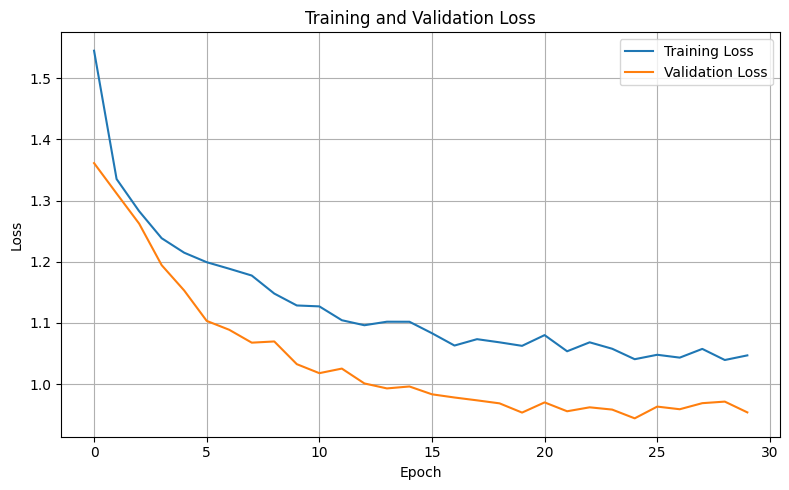

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


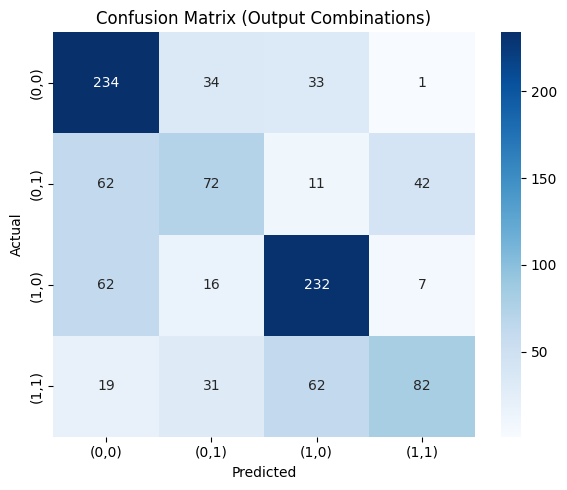

              precision    recall  f1-score   support

       (0,0)       0.62      0.77      0.69       302
       (0,1)       0.47      0.39      0.42       187
       (1,0)       0.69      0.73      0.71       317
       (1,1)       0.62      0.42      0.50       194

    accuracy                           0.62      1000
   macro avg       0.60      0.58      0.58      1000
weighted avg       0.61      0.62      0.61      1000



In [10]:
# --- Feature engineering ---
def prepare_features(df):
    X = df.copy()
    X['Wealth_log'] = np.log1p(X['Wealth'])
    X['Income_log'] = np.log1p(X['Income '])
    X['Income_Wealth_Ratio'] = X['Income '] / X['Wealth'].replace(0, np.nan)
    X['Income_Wealth_Ratio_log'] = np.log1p(X['Income_Wealth_Ratio'].fillna(X['Income '].max()))
    X['Is_Single'] = (X['FamilyMembers'] == 1).astype(int)
    X['Is_Senior'] = (X['Age'] > 65).astype(int)
    X['Has_Education'] = (X['FinancialEducation'] > 0).astype(int)
    X['Risk_Age_Interaction'] = X['RiskPropensity'] * X['Age']

    features = ['Age', 'Gender', 'FamilyMembers', 'FinancialEducation',
                'RiskPropensity', 'Wealth_log', 'Income_log',
                'Income_Wealth_Ratio_log', 'Is_Single', 'Is_Senior',
                'Has_Education', 'Risk_Age_Interaction']

    scaler = MinMaxScaler()
    return pd.DataFrame(scaler.fit_transform(X[features]), columns=features)

# --- Encode target ---
def encode_target(y_df):
    return y_df['AccumulationInvestment'] * 2 + y_df['IncomeInvestment']

# --- Prepara i dati ---
X = prepare_features(needs_df)
y_encoded = encode_target(needs_df[['AccumulationInvestment', 'IncomeInvestment']])
y_cat = to_categorical(y_encoded, num_classes=4)

X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)



model = Sequential([
    Input(shape=(X.shape[1],)),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dropout(0.2),

    Dense(4, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)


# --- Plot delle curve di loss ---
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Predizioni ---
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# --- Etichette per le classi ---
labels = ['(0,0)', '(0,1)', '(1,0)', '(1,1)']

# --- Confusion Matrix ---
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix (Output Combinations)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- Classification Report con etichette ---
print(classification_report(y_test_classes, y_pred_classes, target_names=labels))


In [11]:
# Calcola la correlazione tra i due target
corr = needs_df['AccumulationInvestment'].corr(needs_df['IncomeInvestment'])
print(f"Correlazione tra Accumulation e Income: {corr:.3f}")


Correlazione tra Accumulation e Income: 0.011


classifier separati- voting classifier

F1-score Accumulation (class 1): 0.772
F1-score Income (class 1): 0.623
Macro F1-score (class 1): 0.698


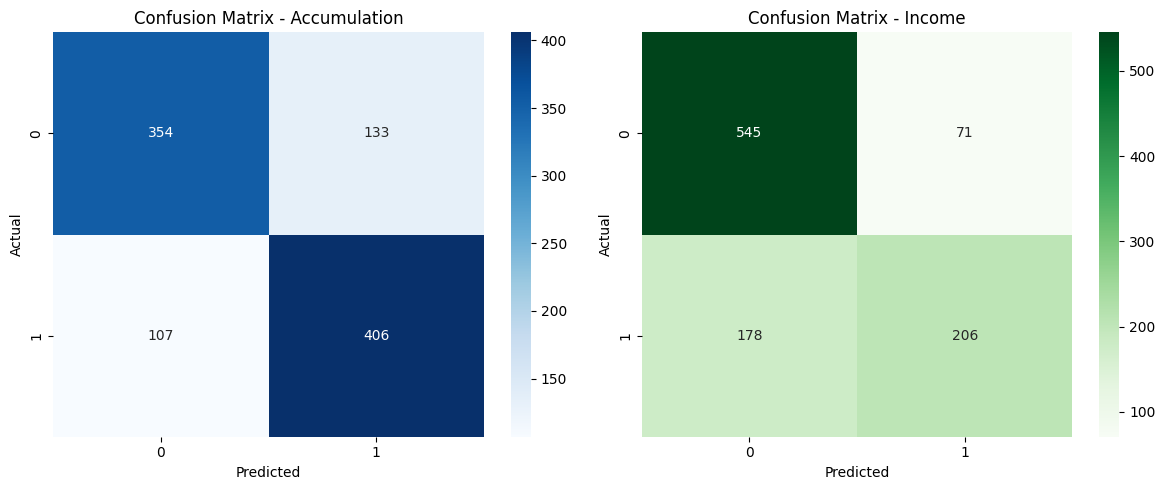


--- Classification Report: AccumulationInvestment ---
              precision    recall  f1-score   support

           0       0.77      0.73      0.75       487
           1       0.75      0.79      0.77       513

    accuracy                           0.76      1000
   macro avg       0.76      0.76      0.76      1000
weighted avg       0.76      0.76      0.76      1000


--- Classification Report: IncomeInvestment ---
              precision    recall  f1-score   support

           0       0.75      0.88      0.81       616
           1       0.74      0.54      0.62       384

    accuracy                           0.75      1000
   macro avg       0.75      0.71      0.72      1000
weighted avg       0.75      0.75      0.74      1000



In [12]:
# 🛠️ FUNZIONE DI FEATURE ENGINEERING
def prepare_features(df):
    X = df.copy()
    X['Wealth_log'] = np.log1p(X['Wealth'])
    X['Income_log'] = np.log1p(X['Income '])
    X['Income_Wealth_Ratio'] = X['Income '] / X['Wealth'].replace(0, np.nan)
    X['Income_Wealth_Ratio_log'] = np.log1p(X['Income_Wealth_Ratio'].fillna(X['Income '].max()))
    X['Is_Single'] = (X['FamilyMembers'] == 1).astype(int)
    X['Is_Senior'] = (X['Age'] > 65).astype(int)
    X['Has_Education'] = (X['FinancialEducation'] > 0).astype(int)
    X['Risk_Age_Interaction'] = X['RiskPropensity'] * X['Age']

    features = ['Age', 'Gender', 'FamilyMembers', 'FinancialEducation',
                'RiskPropensity', 'Wealth_log', 'Income_log',
                'Income_Wealth_Ratio_log', 'Is_Single', 'Is_Senior',
                'Has_Education', 'Risk_Age_Interaction']

    scaler = MinMaxScaler()
    return pd.DataFrame(scaler.fit_transform(X[features]), columns=features)

# 📥 CARICAMENTO DATI: sostituisci questa parte con il tuo file CSV o DataFrame
# needs_df = pd.read_csv('/path/to/your/data.csv')
# Per test temporaneo:
# from sklearn.datasets import make_classification
# needs_df = pd.DataFrame(...)

# 🧠 PREPARAZIONE DEI DATI
X = prepare_features(needs_df)
y_acc = needs_df['AccumulationInvestment']
y_inc = needs_df['IncomeInvestment']

# Split per i due target
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X, y_acc, test_size=0.2, random_state=42, stratify=y_acc)
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X, y_inc, test_size=0.2, random_state=42, stratify=y_inc)

# 🧩 VOTING CLASSIFIER ACCUMULATION
voting_acc = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('lr', LogisticRegression(max_iter=1000)),
        ('nb', GaussianNB())
    ],
    voting='soft'
)

# 🧩 VOTING CLASSIFIER INCOME
voting_inc = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('lr', LogisticRegression(max_iter=1000)),
        ('nb', GaussianNB())
    ],
    voting='soft'
)

# 🏋️‍♂️ TRAINING
voting_acc.fit(X_train_a, y_train_a)
voting_inc.fit(X_train_i, y_train_i)

# 🔮 PREDICTION
y_pred_acc = voting_acc.predict(X_test_a)
y_pred_inc = voting_inc.predict(X_test_i)

# 🎯 F1-score solo sulla classe 1
f1_acc = f1_score(y_test_a, y_pred_acc, pos_label=1)
f1_inc = f1_score(y_test_i, y_pred_inc, pos_label=1)
macro_f1 = np.mean([f1_acc, f1_inc])

print("F1-score Accumulation (class 1):", round(f1_acc, 3))
print("F1-score Income (class 1):", round(f1_inc, 3))
print("Macro F1-score (class 1):", round(macro_f1, 3))

# 📊 CONFUSION MATRICES
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confusion_matrix(y_test_a, y_pred_acc), annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title("Confusion Matrix - Accumulation")
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("Actual")

sns.heatmap(confusion_matrix(y_test_i, y_pred_inc), annot=True, fmt='d', cmap='Greens', ax=axs[1])
axs[1].set_title("Confusion Matrix - Income")
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

# 📄 CLASSIFICATION REPORT (facoltativo)
print("\n--- Classification Report: AccumulationInvestment ---")
print(classification_report(y_test_a, y_pred_acc))
print("\n--- Classification Report: IncomeInvestment ---")
print(classification_report(y_test_i, y_pred_inc))


F1 Accumulation (class 1): 0.798
F1 Income (class 1): 0.648
Macro F1 (class 1): 0.723


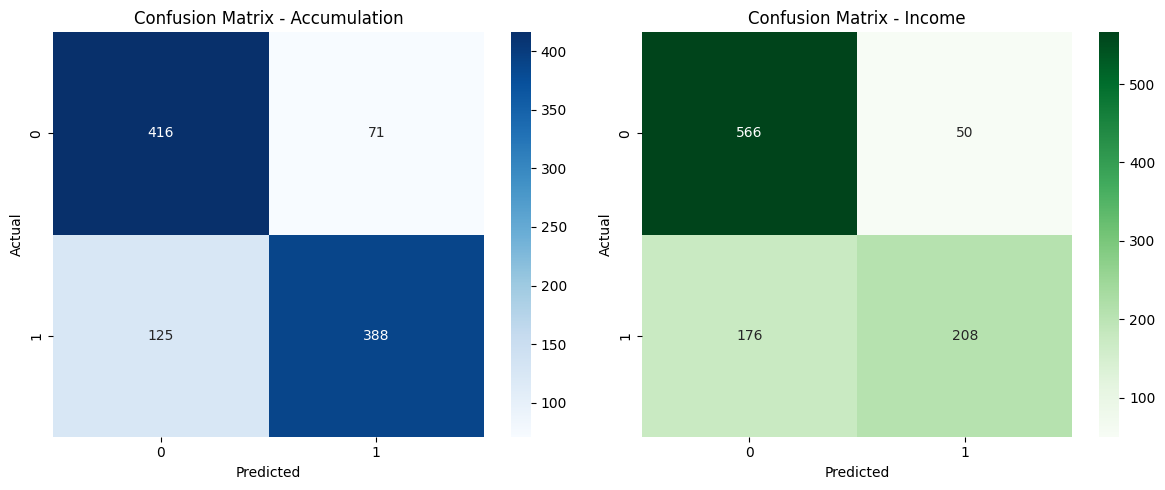


--- Classification Report: AccumulationInvestment ---
              precision    recall  f1-score   support

           0       0.77      0.85      0.81       487
           1       0.85      0.76      0.80       513

    accuracy                           0.80      1000
   macro avg       0.81      0.81      0.80      1000
weighted avg       0.81      0.80      0.80      1000


--- Classification Report: IncomeInvestment ---
              precision    recall  f1-score   support

           0       0.76      0.92      0.83       616
           1       0.81      0.54      0.65       384

    accuracy                           0.77      1000
   macro avg       0.78      0.73      0.74      1000
weighted avg       0.78      0.77      0.76      1000



In [13]:
# ⚙️ FEATURE ENGINEERING
def prepare_features(df):
    X = df.copy()
    X['Wealth_log'] = np.log1p(X['Wealth'])
    X['Income_log'] = np.log1p(X['Income '])
    X['Income_Wealth_Ratio'] = X['Income '] / X['Wealth'].replace(0, np.nan)
    X['Income_Wealth_Ratio_log'] = np.log1p(X['Income_Wealth_Ratio'].fillna(X['Income '].max()))
    X['Is_Single'] = (X['FamilyMembers'] == 1).astype(int)
    X['Is_Senior'] = (X['Age'] > 65).astype(int)
    X['Has_Education'] = (X['FinancialEducation'] > 0).astype(int)
    X['Risk_Age_Interaction'] = X['RiskPropensity'] * X['Age']

    features = ['Age', 'Gender', 'FamilyMembers', 'FinancialEducation',
                'RiskPropensity', 'Wealth_log', 'Income_log',
                'Income_Wealth_Ratio_log', 'Is_Single', 'Is_Senior',
                'Has_Education', 'Risk_Age_Interaction']

    scaler = MinMaxScaler()
    return pd.DataFrame(scaler.fit_transform(X[features]), columns=features)

# 🧠 PREPARAZIONE
X = prepare_features(needs_df)
y_acc = needs_df['AccumulationInvestment']
y_inc = needs_df['IncomeInvestment']

X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X, y_acc, test_size=0.2, random_state=42, stratify=y_acc)
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X, y_inc, test_size=0.2, random_state=42, stratify=y_inc)

# 🧩 MODELLI
rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

# ✅ VotingClassifier per ACCUMULATION
voting_acc = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb), ('knn', knn)],
    voting='soft'
)

# ✅ VotingClassifier per INCOME
voting_inc = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb), ('knn', knn)],
    voting='soft'
)

# 🏋️‍♂️ TRAINING
voting_acc.fit(X_train_a, y_train_a)
voting_inc.fit(X_train_i, y_train_i)

# 🔮 PREDICT
y_pred_acc = voting_acc.predict(X_test_a)
y_pred_inc = voting_inc.predict(X_test_i)

# 🎯 F1 METRICS sulla classe 1
f1_acc = f1_score(y_test_a, y_pred_acc, pos_label=1)
f1_inc = f1_score(y_test_i, y_pred_inc, pos_label=1)
macro_f1 = np.mean([f1_acc, f1_inc])

print("F1 Accumulation (class 1):", round(f1_acc, 3))
print("F1 Income (class 1):", round(f1_inc, 3))
print("Macro F1 (class 1):", round(macro_f1, 3))

# 📊 CONFUSION MATRICES
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confusion_matrix(y_test_a, y_pred_acc), annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title("Confusion Matrix - Accumulation")
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("Actual")

sns.heatmap(confusion_matrix(y_test_i, y_pred_inc), annot=True, fmt='d', cmap='Greens', ax=axs[1])
axs[1].set_title("Confusion Matrix - Income")
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

# 📄 CLASSIFICATION REPORT (facoltativo)
print("\n--- Classification Report: AccumulationInvestment ---")
print(classification_report(y_test_a, y_pred_acc))
print("\n--- Classification Report: IncomeInvestment ---")
print(classification_report(y_test_i, y_pred_inc))


F1 Accumulation (class 1): 0.8
F1 Income (class 1): 0.633
Macro F1 (class 1): 0.716


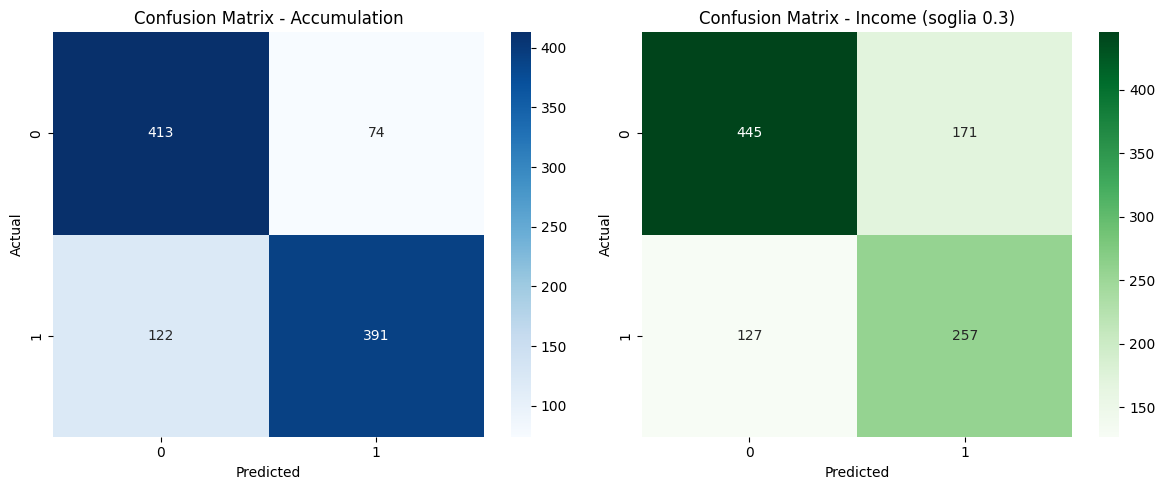


--- Classification Report: AccumulationInvestment ---
              precision    recall  f1-score   support

           0      0.772     0.848     0.808       487
           1      0.841     0.762     0.800       513

    accuracy                          0.804      1000
   macro avg      0.806     0.805     0.804      1000
weighted avg      0.807     0.804     0.804      1000


--- Classification Report: IncomeInvestment (soglia 0.3) ---
              precision    recall  f1-score   support

           0      0.778     0.722     0.749       616
           1      0.600     0.669     0.633       384

    accuracy                          0.702      1000
   macro avg      0.689     0.696     0.691      1000
weighted avg      0.710     0.702     0.705      1000



In [14]:
# ⚙️ FEATURE ENGINEERING
def prepare_features(df):
    X = df.copy()
    X['Wealth_log'] = np.log1p(X['Wealth'])
    X['Income_log'] = np.log1p(X['Income '])
    X['Income_Wealth_Ratio'] = X['Income '] / X['Wealth'].replace(0, np.nan)
    X['Income_Wealth_Ratio_log'] = np.log1p(X['Income_Wealth_Ratio'].fillna(X['Income '].max()))
    X['Is_Single'] = (X['FamilyMembers'] == 1).astype(int)
    X['Is_Senior'] = (X['Age'] > 65).astype(int)
    X['Has_Education'] = (X['FinancialEducation'] > 0).astype(int)
    X['Risk_Age_Interaction'] = X['RiskPropensity'] * X['Age']

    features = ['Age', 'Gender', 'FamilyMembers', 'FinancialEducation',
                'RiskPropensity', 'Wealth_log', 'Income_log',
                'Income_Wealth_Ratio_log', 'Is_Single', 'Is_Senior',
                'Has_Education', 'Risk_Age_Interaction']

    scaler = MinMaxScaler()
    return pd.DataFrame(scaler.fit_transform(X[features]), columns=features)

# ⚖️ scale_pos_weight for XGBoost
def get_scale_pos_weight(y):
    return (y == 0).sum() / (y == 1).sum()

# 🧠 PREPARAZIONE
X = prepare_features(needs_df)
y_acc = needs_df['AccumulationInvestment']
y_inc = needs_df['IncomeInvestment']

X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X, y_acc, test_size=0.2, random_state=42, stratify=y_acc)
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X, y_inc, test_size=0.2, random_state=42, stratify=y_inc)

# 🧩 MODELLI CON CLASS BALANCING
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
xgb_acc = XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                        scale_pos_weight=get_scale_pos_weight(y_train_a), random_state=42)
xgb_inc = XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                        scale_pos_weight=get_scale_pos_weight(y_train_i), random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

# ✅ VotingClassifier per ACCUMULATION
voting_acc = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb_acc), ('knn', knn)],
    voting='soft'
)

# ✅ VotingClassifier per INCOME
voting_inc = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb_inc), ('knn', knn)],
    voting='soft'
)

# 🏋️‍♂️ TRAINING
voting_acc.fit(X_train_a, y_train_a)
voting_inc.fit(X_train_i, y_train_i)

# 🔮 PREDICT ACCUMULATION
y_pred_acc = voting_acc.predict(X_test_a)

# 🔮 PREDICT INCOME con soglia custom
probs_inc = voting_inc.predict_proba(X_test_i)
probs_class1 = probs_inc[:, 1] if isinstance(probs_inc, np.ndarray) else probs_inc[1][:, 1]

# 👇 MODIFICA LA SOGLIA QUI
threshold = 0.3
y_pred_inc = (probs_class1 >= threshold).astype(int)

# 🎯 F1 e recall METRICS
f1_acc = f1_score(y_test_a, y_pred_acc, pos_label=1)
f1_inc = f1_score(y_test_i, y_pred_inc, pos_label=1)
macro_f1 = np.mean([f1_acc, f1_inc])

print("F1 Accumulation (class 1):", round(f1_acc, 3))
print("F1 Income (class 1):", round(f1_inc, 3))
print("Macro F1 (class 1):", round(macro_f1, 3))

# 📊 CONFUSION MATRICES
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confusion_matrix(y_test_a, y_pred_acc), annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title("Confusion Matrix - Accumulation")
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("Actual")

sns.heatmap(confusion_matrix(y_test_i, y_pred_inc), annot=True, fmt='d', cmap='Greens', ax=axs[1])
axs[1].set_title(f"Confusion Matrix - Income (soglia {threshold})")
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

# 📄 CLASSIFICATION REPORT
print("\n--- Classification Report: AccumulationInvestment ---")
print(classification_report(y_test_a, y_pred_acc, digits=3))
print(f"\n--- Classification Report: IncomeInvestment (soglia {threshold}) ---")
print(classification_report(y_test_i, y_pred_inc, digits=3))



massimizzo recall con threshold personalizzata a 0.25 e uso non knn ma regression più adatto al soft voting

F1-score Accumulation (class 1): 0.808
F1-score Income (class 1): 0.587
Macro F1-score (class 1): 0.697


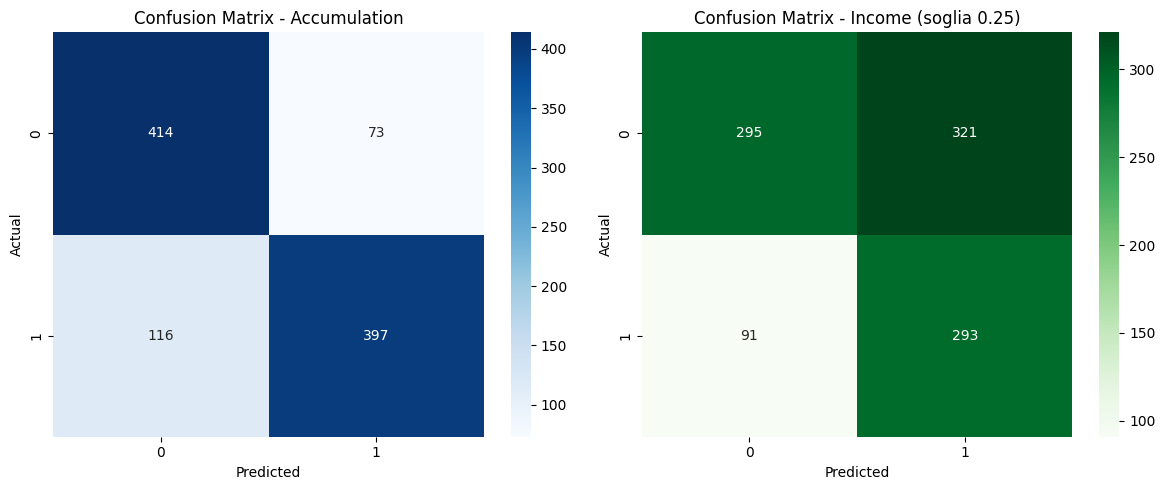


--- Classification Report: AccumulationInvestment ---
              precision    recall  f1-score   support

           0      0.781     0.850     0.814       487
           1      0.845     0.774     0.808       513

    accuracy                          0.811      1000
   macro avg      0.813     0.812     0.811      1000
weighted avg      0.814     0.811     0.811      1000


--- Classification Report: IncomeInvestment (soglia 0.25) ---
              precision    recall  f1-score   support

           0      0.764     0.479     0.589       616
           1      0.477     0.763     0.587       384

    accuracy                          0.588      1000
   macro avg      0.621     0.621     0.588      1000
weighted avg      0.654     0.588     0.588      1000



In [15]:
# ⚙️ FEATURE ENGINEERING
def prepare_features(df):
    X = df.copy()
    X['Wealth_log'] = np.log1p(X['Wealth'])
    X['Income_log'] = np.log1p(X['Income '])
    X['Income_Wealth_Ratio'] = X['Income '] / X['Wealth'].replace(0, np.nan)
    X['Income_Wealth_Ratio_log'] = np.log1p(X['Income_Wealth_Ratio'].fillna(X['Income '].max()))
    X['Is_Single'] = (X['FamilyMembers'] == 1).astype(int)
    X['Is_Senior'] = (X['Age'] > 65).astype(int)
    X['Has_Education'] = (X['FinancialEducation'] > 0).astype(int)
    X['Risk_Age_Interaction'] = X['RiskPropensity'] * X['Age']

    features = ['Age', 'Gender', 'FamilyMembers', 'FinancialEducation',
                'RiskPropensity', 'Wealth_log', 'Income_log',
                'Income_Wealth_Ratio_log', 'Is_Single', 'Is_Senior',
                'Has_Education', 'Risk_Age_Interaction']

    scaler = MinMaxScaler()
    return pd.DataFrame(scaler.fit_transform(X[features]), columns=features)

# ⚖️ Calcolo scale_pos_weight per XGBoost
def get_scale_pos_weight(y):
    return (y == 0).sum() / (y == 1).sum()

# 🧠 PREPARAZIONE DATI
X = prepare_features(needs_df)
y_acc = needs_df['AccumulationInvestment']
y_inc = needs_df['IncomeInvestment']

X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X, y_acc, test_size=0.2, random_state=42, stratify=y_acc)
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X, y_inc, test_size=0.2, random_state=42, stratify=y_inc)

# 🧩 MODELLI CON BILANCIAMENTO CLASSI
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
xgb_acc = XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                        scale_pos_weight=get_scale_pos_weight(y_train_a), random_state=42)
xgb_inc = XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                        scale_pos_weight=get_scale_pos_weight(y_train_i), random_state=42)
lr = LogisticRegression(max_iter=1000, class_weight='balanced')

# ✅ VotingClassifier per ACCUMULATION
voting_acc = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb_acc), ('lr', lr)],
    voting='soft'
)

# ✅ VotingClassifier per INCOME (con XGB specifico)
voting_inc = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb_inc), ('lr', lr)],
    voting='soft'
)

# 🏋️‍♂️ TRAINING
voting_acc.fit(X_train_a, y_train_a)
voting_inc.fit(X_train_i, y_train_i)

# 🔮 PREDICT ACCUMULATION
y_pred_acc = voting_acc.predict(X_test_a)

# 🔮 PREDICT INCOME con threshold personalizzato
probs_inc = voting_inc.predict_proba(X_test_i)
probs_class1 = probs_inc[:, 1] if isinstance(probs_inc, np.ndarray) else probs_inc[1][:, 1]

# 👇 SOGLIA PERSONALIZZATA PER MASSIMIZZARE RECALL
threshold = 0.25
y_pred_inc = (probs_class1 >= threshold).astype(int)

# 🎯 METRICHE F1 E RECALL
f1_acc = f1_score(y_test_a, y_pred_acc, pos_label=1)
f1_inc = f1_score(y_test_i, y_pred_inc, pos_label=1)
macro_f1 = np.mean([f1_acc, f1_inc])

print("F1-score Accumulation (class 1):", round(f1_acc, 3))
print("F1-score Income (class 1):", round(f1_inc, 3))
print("Macro F1-score (class 1):", round(macro_f1, 3))

# 📊 CONFUSION MATRICES
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confusion_matrix(y_test_a, y_pred_acc), annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title("Confusion Matrix - Accumulation")
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("Actual")

sns.heatmap(confusion_matrix(y_test_i, y_pred_inc), annot=True, fmt='d', cmap='Greens', ax=axs[1])
axs[1].set_title(f"Confusion Matrix - Income (soglia {threshold})")
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

# 📄 REPORT CLASSIFICAZIONE
print("\n--- Classification Report: AccumulationInvestment ---")
print(classification_report(y_test_a, y_pred_acc, digits=3))
print(f"\n--- Classification Report: IncomeInvestment (soglia {threshold}) ---")
print(classification_report(y_test_i, y_pred_inc, digits=3))



massimizzo recall con threshold personalizzata a 0.3 e uso non knn ma regression più adatto al soft voting

F1-score Accumulation (class 1): 0.808
F1-score Income (class 1): 0.623
Macro F1-score (class 1): 0.715


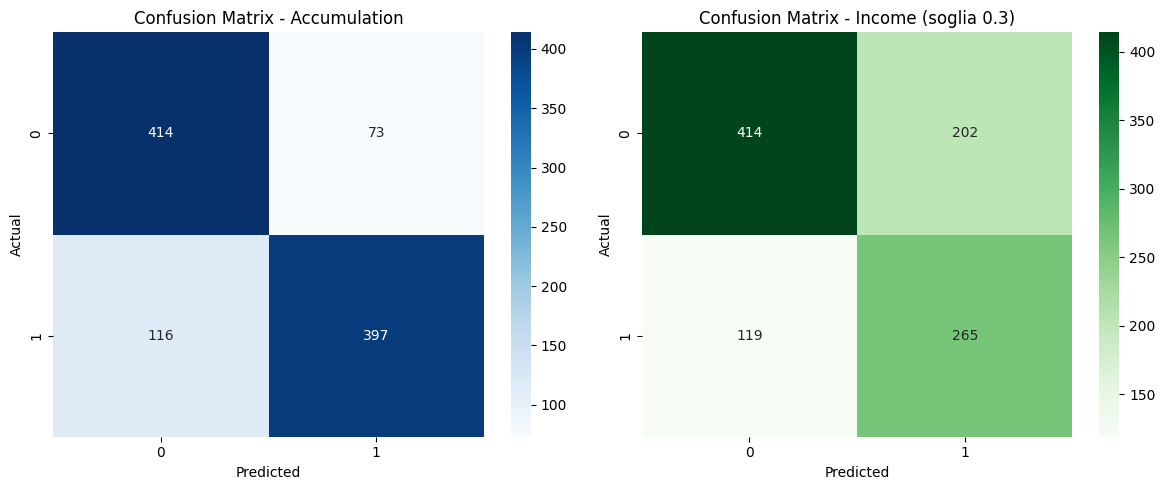


--- Classification Report: AccumulationInvestment ---
              precision    recall  f1-score   support

           0      0.781     0.850     0.814       487
           1      0.845     0.774     0.808       513

    accuracy                          0.811      1000
   macro avg      0.813     0.812     0.811      1000
weighted avg      0.814     0.811     0.811      1000


--- Classification Report: IncomeInvestment (soglia 0.3) ---
              precision    recall  f1-score   support

           0      0.777     0.672     0.721       616
           1      0.567     0.690     0.623       384

    accuracy                          0.679      1000
   macro avg      0.672     0.681     0.672      1000
weighted avg      0.696     0.679     0.683      1000



In [16]:
# ⚙️ FEATURE ENGINEERING
def prepare_features(df):
    X = df.copy()
    X['Wealth_log'] = np.log1p(X['Wealth'])
    X['Income_log'] = np.log1p(X['Income '])
    X['Income_Wealth_Ratio'] = X['Income '] / X['Wealth'].replace(0, np.nan)
    X['Income_Wealth_Ratio_log'] = np.log1p(X['Income_Wealth_Ratio'].fillna(X['Income '].max()))
    X['Is_Single'] = (X['FamilyMembers'] == 1).astype(int)
    X['Is_Senior'] = (X['Age'] > 65).astype(int)
    X['Has_Education'] = (X['FinancialEducation'] > 0).astype(int)
    X['Risk_Age_Interaction'] = X['RiskPropensity'] * X['Age']

    features = ['Age', 'Gender', 'FamilyMembers', 'FinancialEducation',
                'RiskPropensity', 'Wealth_log', 'Income_log',
                'Income_Wealth_Ratio_log', 'Is_Single', 'Is_Senior',
                'Has_Education', 'Risk_Age_Interaction']

    scaler = MinMaxScaler()
    return pd.DataFrame(scaler.fit_transform(X[features]), columns=features)

# ⚖️ Calcolo scale_pos_weight per XGBoost
def get_scale_pos_weight(y):
    return (y == 0).sum() / (y == 1).sum()

# 🧠 PREPARAZIONE DATI
X = prepare_features(needs_df)
y_acc = needs_df['AccumulationInvestment']
y_inc = needs_df['IncomeInvestment']

X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X, y_acc, test_size=0.2, random_state=42, stratify=y_acc)
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X, y_inc, test_size=0.2, random_state=42, stratify=y_inc)

# 🧩 MODELLI CON BILANCIAMENTO CLASSI
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
xgb_acc = XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                        scale_pos_weight=get_scale_pos_weight(y_train_a), random_state=42)
xgb_inc = XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                        scale_pos_weight=get_scale_pos_weight(y_train_i), random_state=42)
lr = LogisticRegression(max_iter=1000, class_weight='balanced')

# ✅ VotingClassifier per ACCUMULATION
voting_acc = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb_acc), ('lr', lr)],
    voting='soft'
)

# ✅ VotingClassifier per INCOME (con XGB specifico)
voting_inc = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb_inc), ('lr', lr)],
    voting='soft'
)

# 🏋️‍♂️ TRAINING
voting_acc.fit(X_train_a, y_train_a)
voting_inc.fit(X_train_i, y_train_i)

# 🔮 PREDICT ACCUMULATION
y_pred_acc = voting_acc.predict(X_test_a)

# 🔮 PREDICT INCOME con threshold personalizzato
probs_inc = voting_inc.predict_proba(X_test_i)
probs_class1 = probs_inc[:, 1] if isinstance(probs_inc, np.ndarray) else probs_inc[1][:, 1]

# 👇 SOGLIA PERSONALIZZATA PER MASSIMIZZARE RECALL
threshold = 0.3
y_pred_inc = (probs_class1 >= threshold).astype(int)

# 🎯 METRICHE F1 E RECALL
f1_acc = f1_score(y_test_a, y_pred_acc, pos_label=1)
f1_inc = f1_score(y_test_i, y_pred_inc, pos_label=1)
macro_f1 = np.mean([f1_acc, f1_inc])

print("F1-score Accumulation (class 1):", round(f1_acc, 3))
print("F1-score Income (class 1):", round(f1_inc, 3))
print("Macro F1-score (class 1):", round(macro_f1, 3))

# 📊 CONFUSION MATRICES
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confusion_matrix(y_test_a, y_pred_acc), annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title("Confusion Matrix - Accumulation")
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("Actual")

sns.heatmap(confusion_matrix(y_test_i, y_pred_inc), annot=True, fmt='d', cmap='Greens', ax=axs[1])
axs[1].set_title(f"Confusion Matrix - Income (soglia {threshold})")
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

# 📄 REPORT CLASSIFICAZIONE
print("\n--- Classification Report: AccumulationInvestment ---")
print(classification_report(y_test_a, y_pred_acc, digits=3))
print(f"\n--- Classification Report: IncomeInvestment (soglia {threshold}) ---")
print(classification_report(y_test_i, y_pred_inc, digits=3))


massimizzo recall con threshold personalizzata a 0.20 e uso non knn ma regression più adatto al soft voting

F1-score Accumulation (class 1): 0.808
F1-score Income (class 1): 0.565
Macro F1-score (class 1): 0.686


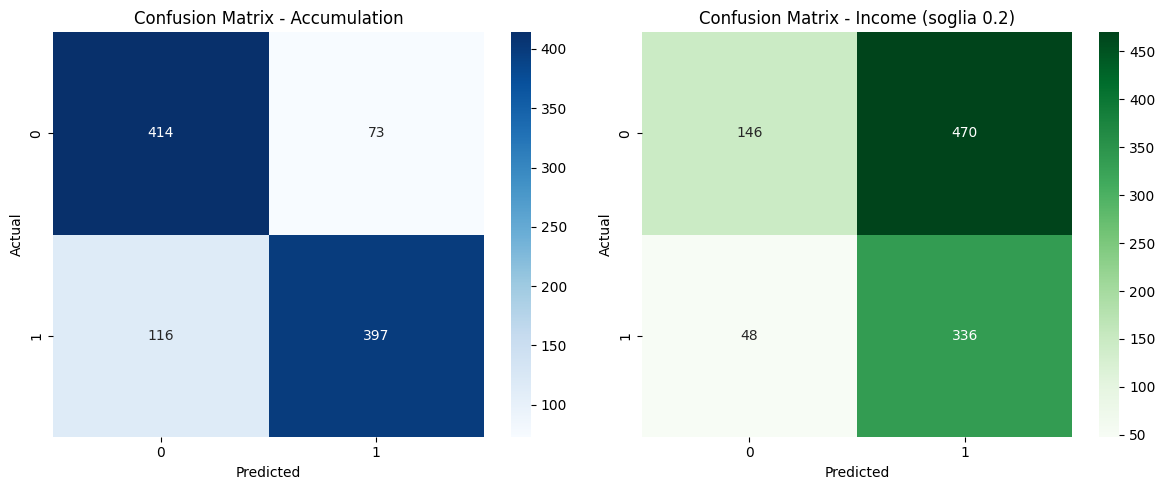


--- Classification Report: AccumulationInvestment ---
              precision    recall  f1-score   support

           0      0.781     0.850     0.814       487
           1      0.845     0.774     0.808       513

    accuracy                          0.811      1000
   macro avg      0.813     0.812     0.811      1000
weighted avg      0.814     0.811     0.811      1000


--- Classification Report: IncomeInvestment (soglia 0.2) ---
              precision    recall  f1-score   support

           0      0.753     0.237     0.360       616
           1      0.417     0.875     0.565       384

    accuracy                          0.482      1000
   macro avg      0.585     0.556     0.463      1000
weighted avg      0.624     0.482     0.439      1000



In [17]:
# ⚙️ FEATURE ENGINEERING
def prepare_features(df):
    X = df.copy()
    X['Wealth_log'] = np.log1p(X['Wealth'])
    X['Income_log'] = np.log1p(X['Income '])
    X['Income_Wealth_Ratio'] = X['Income '] / X['Wealth'].replace(0, np.nan)
    X['Income_Wealth_Ratio_log'] = np.log1p(X['Income_Wealth_Ratio'].fillna(X['Income '].max()))
    X['Is_Single'] = (X['FamilyMembers'] == 1).astype(int)
    X['Is_Senior'] = (X['Age'] > 65).astype(int)
    X['Has_Education'] = (X['FinancialEducation'] > 0).astype(int)
    X['Risk_Age_Interaction'] = X['RiskPropensity'] * X['Age']

    features = ['Age', 'Gender', 'FamilyMembers', 'FinancialEducation',
                'RiskPropensity', 'Wealth_log', 'Income_log',
                'Income_Wealth_Ratio_log', 'Is_Single', 'Is_Senior',
                'Has_Education', 'Risk_Age_Interaction']

    scaler = MinMaxScaler()
    return pd.DataFrame(scaler.fit_transform(X[features]), columns=features)

# ⚖️ Calcolo scale_pos_weight per XGBoost
def get_scale_pos_weight(y):
    return (y == 0).sum() / (y == 1).sum()

# 🧠 PREPARAZIONE DATI
X = prepare_features(needs_df)
y_acc = needs_df['AccumulationInvestment']
y_inc = needs_df['IncomeInvestment']

X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X, y_acc, test_size=0.2, random_state=42, stratify=y_acc)
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X, y_inc, test_size=0.2, random_state=42, stratify=y_inc)

# 🧩 MODELLI CON BILANCIAMENTO CLASSI
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
xgb_acc = XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                        scale_pos_weight=get_scale_pos_weight(y_train_a), random_state=42)
xgb_inc = XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                        scale_pos_weight=get_scale_pos_weight(y_train_i), random_state=42)
lr = LogisticRegression(max_iter=1000, class_weight='balanced')

# ✅ VotingClassifier per ACCUMULATION
voting_acc = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb_acc), ('lr', lr)],
    voting='soft'
)

# ✅ VotingClassifier per INCOME (con XGB specifico)
voting_inc = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb_inc), ('lr', lr)],
    voting='soft'
)

# 🏋️‍♂️ TRAINING
voting_acc.fit(X_train_a, y_train_a)
voting_inc.fit(X_train_i, y_train_i)

# 🔮 PREDICT ACCUMULATION
y_pred_acc = voting_acc.predict(X_test_a)

# 🔮 PREDICT INCOME con threshold personalizzato
probs_inc = voting_inc.predict_proba(X_test_i)
probs_class1 = probs_inc[:, 1] if isinstance(probs_inc, np.ndarray) else probs_inc[1][:, 1]

# 👇 SOGLIA PERSONALIZZATA PER MASSIMIZZARE RECALL
threshold = 0.2
y_pred_inc = (probs_class1 >= threshold).astype(int)

# 🎯 METRICHE F1 E RECALL
f1_acc = f1_score(y_test_a, y_pred_acc, pos_label=1)
f1_inc = f1_score(y_test_i, y_pred_inc, pos_label=1)
macro_f1 = np.mean([f1_acc, f1_inc])

print("F1-score Accumulation (class 1):", round(f1_acc, 3))
print("F1-score Income (class 1):", round(f1_inc, 3))
print("Macro F1-score (class 1):", round(macro_f1, 3))

# 📊 CONFUSION MATRICES
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confusion_matrix(y_test_a, y_pred_acc), annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title("Confusion Matrix - Accumulation")
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("Actual")

sns.heatmap(confusion_matrix(y_test_i, y_pred_inc), annot=True, fmt='d', cmap='Greens', ax=axs[1])
axs[1].set_title(f"Confusion Matrix - Income (soglia {threshold})")
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

# 📄 REPORT CLASSIFICAZIONE
print("\n--- Classification Report: AccumulationInvestment ---")
print(classification_report(y_test_a, y_pred_acc, digits=3))
print(f"\n--- Classification Report: IncomeInvestment (soglia {threshold}) ---")
print(classification_report(y_test_i, y_pred_inc, digits=3))

curva precision-recall per capire soglia ottimale

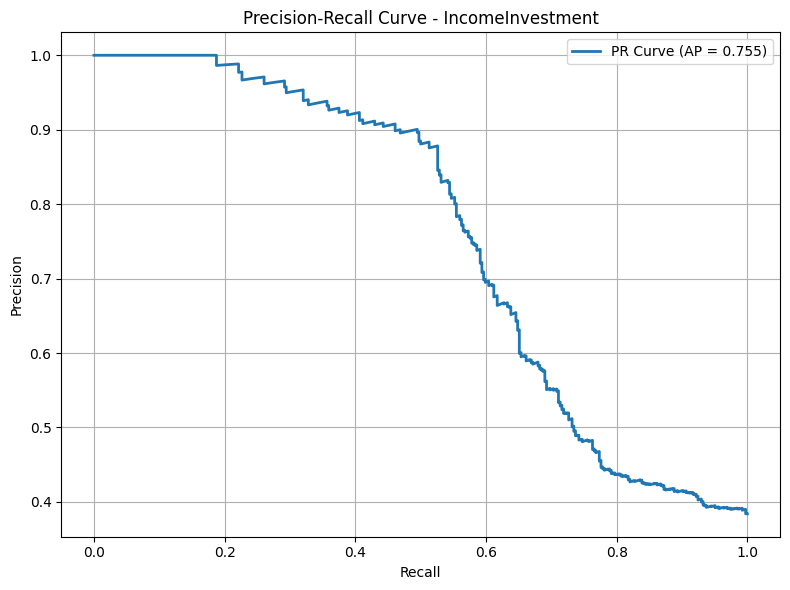

Soglia: 0.03 → Precision: 0.38, Recall: 1.00
Soglia: 0.12 → Precision: 0.39, Recall: 0.99
Soglia: 0.14 → Precision: 0.39, Recall: 0.96
Soglia: 0.16 → Precision: 0.39, Recall: 0.93
Soglia: 0.17 → Precision: 0.40, Recall: 0.92
Soglia: 0.19 → Precision: 0.41, Recall: 0.91
Soglia: 0.20 → Precision: 0.42, Recall: 0.89
Soglia: 0.20 → Precision: 0.42, Recall: 0.87
Soglia: 0.21 → Precision: 0.42, Recall: 0.84
Soglia: 0.22 → Precision: 0.43, Recall: 0.82
Soglia: 0.23 → Precision: 0.44, Recall: 0.80
Soglia: 0.24 → Precision: 0.45, Recall: 0.78
Soglia: 0.24 → Precision: 0.46, Recall: 0.77
Soglia: 0.25 → Precision: 0.48, Recall: 0.76
Soglia: 0.26 → Precision: 0.49, Recall: 0.74
Soglia: 0.27 → Precision: 0.51, Recall: 0.73
Soglia: 0.28 → Precision: 0.53, Recall: 0.72
Soglia: 0.29 → Precision: 0.55, Recall: 0.70
Soglia: 0.30 → Precision: 0.58, Recall: 0.69
Soglia: 0.32 → Precision: 0.59, Recall: 0.66
Soglia: 0.33 → Precision: 0.62, Recall: 0.65
Soglia: 0.35 → Precision: 0.66, Recall: 0.64
Soglia: 0.

In [18]:
# Calcola precision, recall e threshold
precision, recall, thresholds = precision_recall_curve(y_test_i, probs_class1)

# Calcola Average Precision Score
aps = average_precision_score(y_test_i, probs_class1)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AP = {aps:.3f})', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - IncomeInvestment')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# (Facoltativo) Stampa soglie campione
for r, p, t in zip(recall[::30], precision[::30], thresholds[::30]):
    print(f"Soglia: {t:.2f} → Precision: {p:.2f}, Recall: {r:.2f}")


classifier con random forest xcgboost e regression

F1 Accumulation (class 1): 0.808
F1 Income (class 1): 0.587
Macro F1 (class 1): 0.697


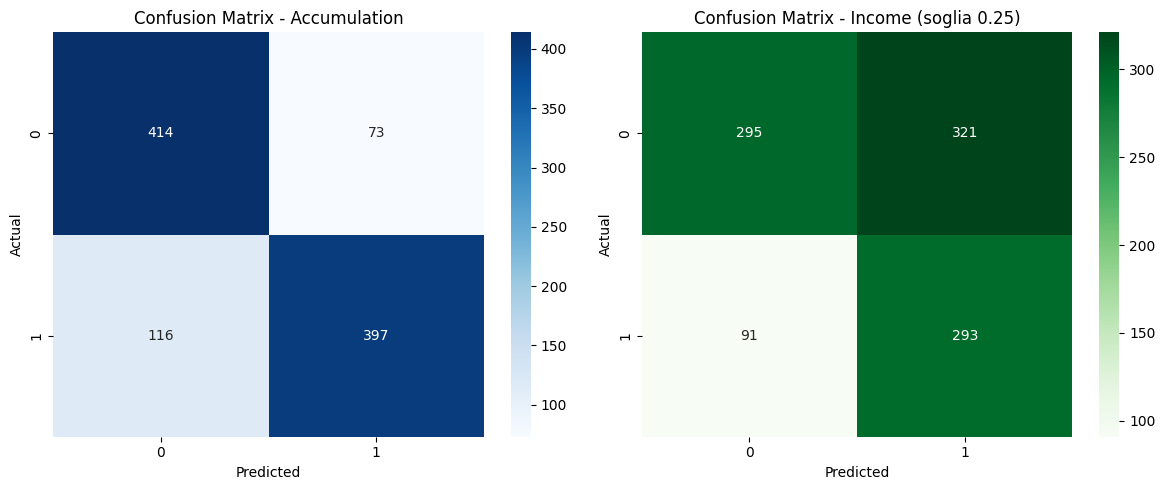


--- Classification Report: AccumulationInvestment ---
              precision    recall  f1-score   support

           0      0.781     0.850     0.814       487
           1      0.845     0.774     0.808       513

    accuracy                          0.811      1000
   macro avg      0.813     0.812     0.811      1000
weighted avg      0.814     0.811     0.811      1000


--- Classification Report: IncomeInvestment (soglia 0.25) ---
              precision    recall  f1-score   support

           0      0.764     0.479     0.589       616
           1      0.477     0.763     0.587       384

    accuracy                          0.588      1000
   macro avg      0.621     0.621     0.588      1000
weighted avg      0.654     0.588     0.588      1000



In [19]:
# ⚙️ FEATURE ENGINEERING
def prepare_features(df):
    X = df.copy()
    X['Wealth_log'] = np.log1p(X['Wealth'])
    X['Income_log'] = np.log1p(X['Income '])
    X['Income_Wealth_Ratio'] = X['Income '] / X['Wealth'].replace(0, np.nan)
    X['Income_Wealth_Ratio_log'] = np.log1p(X['Income_Wealth_Ratio'].fillna(X['Income '].max()))
    X['Is_Single'] = (X['FamilyMembers'] == 1).astype(int)
    X['Is_Senior'] = (X['Age'] > 65).astype(int)
    X['Has_Education'] = (X['FinancialEducation'] > 0).astype(int)
    X['Risk_Age_Interaction'] = X['RiskPropensity'] * X['Age']

    features = ['Age', 'Gender', 'FamilyMembers', 'FinancialEducation',
                'RiskPropensity', 'Wealth_log', 'Income_log',
                'Income_Wealth_Ratio_log', 'Is_Single', 'Is_Senior',
                'Has_Education', 'Risk_Age_Interaction']

    scaler = MinMaxScaler()
    return pd.DataFrame(scaler.fit_transform(X[features]), columns=features)

# ⚖️ Calcolo scale_pos_weight per XGBoost
def get_scale_pos_weight(y):
    return (y == 0).sum() / (y == 1).sum()

# 🧠 PREPARAZIONE DATI
X = prepare_features(needs_df)
y_acc = needs_df['AccumulationInvestment']
y_inc = needs_df['IncomeInvestment']

X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X, y_acc, test_size=0.2, random_state=42, stratify=y_acc)
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X, y_inc, test_size=0.2, random_state=42, stratify=y_inc)

# 🧩 MODELLI INCLUSI NEL VOTING
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
xgb_acc = XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                        scale_pos_weight=get_scale_pos_weight(y_train_a), random_state=42)
xgb_inc = XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                        scale_pos_weight=get_scale_pos_weight(y_train_i), random_state=42)
lr = LogisticRegression(max_iter=1000, class_weight='balanced')

# ✅ VotingClassifier per ACCUMULATION
voting_acc = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb_acc), ('lr', lr)],
    voting='soft'
)

# ✅ VotingClassifier per INCOME
voting_inc = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb_inc), ('lr', lr)],
    voting='soft'
)

# 🏋️‍♂️ TRAINING
voting_acc.fit(X_train_a, y_train_a)
voting_inc.fit(X_train_i, y_train_i)

# 🔮 PREDICT ACCUMULATION
y_pred_acc = voting_acc.predict(X_test_a)

# 🔮 PREDICT INCOME con threshold personalizzato
probs_inc = voting_inc.predict_proba(X_test_i)
probs_class1 = probs_inc[:, 1] if isinstance(probs_inc, np.ndarray) else probs_inc[1][:, 1]

# 👇 SOGLIA PERSONALIZZATA PER MAX RECALL
threshold = 0.25
y_pred_inc = (probs_class1 >= threshold).astype(int)

# 🎯 METRICHE
f1_acc = f1_score(y_test_a, y_pred_acc, pos_label=1)
f1_inc = f1_score(y_test_i, y_pred_inc, pos_label=1)
macro_f1 = np.mean([f1_acc, f1_inc])

print("F1 Accumulation (class 1):", round(f1_acc, 3))
print("F1 Income (class 1):", round(f1_inc, 3))
print("Macro F1 (class 1):", round(macro_f1, 3))

# 📊 CONFUSION MATRICES
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confusion_matrix(y_test_a, y_pred_acc), annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title("Confusion Matrix - Accumulation")
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("Actual")

sns.heatmap(confusion_matrix(y_test_i, y_pred_inc), annot=True, fmt='d', cmap='Greens', ax=axs[1])
axs[1].set_title(f"Confusion Matrix - Income (soglia {threshold})")
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

# 📄 CLASSIFICATION REPORT
print("\n--- Classification Report: AccumulationInvestment ---")
print(classification_report(y_test_a, y_pred_acc, digits=3))
print(f"\n--- Classification Report: IncomeInvestment (soglia {threshold}) ---")
print(classification_report(y_test_i, y_pred_inc, digits=3))


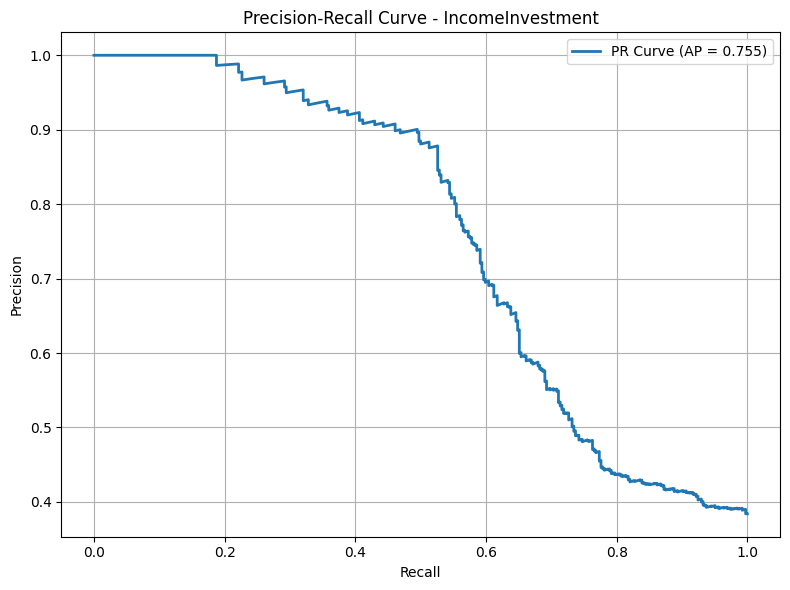

Soglia = 0.03 → Precision = 0.38, Recall = 1.00
Soglia = 0.17 → Precision = 0.40, Recall = 0.93
Soglia = 0.20 → Precision = 0.42, Recall = 0.87
Soglia = 0.23 → Precision = 0.44, Recall = 0.80
Soglia = 0.25 → Precision = 0.48, Recall = 0.76
Soglia = 0.29 → Precision = 0.55, Recall = 0.71
Soglia = 0.33 → Precision = 0.62, Recall = 0.65
Soglia = 0.41 → Precision = 0.75, Recall = 0.58
Soglia = 0.76 → Precision = 0.90, Recall = 0.47
Soglia = 0.92 → Precision = 0.97, Recall = 0.25


In [20]:
# Calcola precision, recall e soglie
precision, recall, thresholds = precision_recall_curve(y_test_i, probs_class1)
aps = average_precision_score(y_test_i, probs_class1)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AP = {aps:.3f})', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - IncomeInvestment')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# (Facoltativo) Mostra soglie a intervalli
for i in range(0, len(thresholds), max(1, len(thresholds) // 10)):
    print(f"Soglia = {thresholds[i]:.2f} → Precision = {precision[i]:.2f}, Recall = {recall[i]:.2f}")


F1-score Income (class 1) con soglia 0.28: 0.643


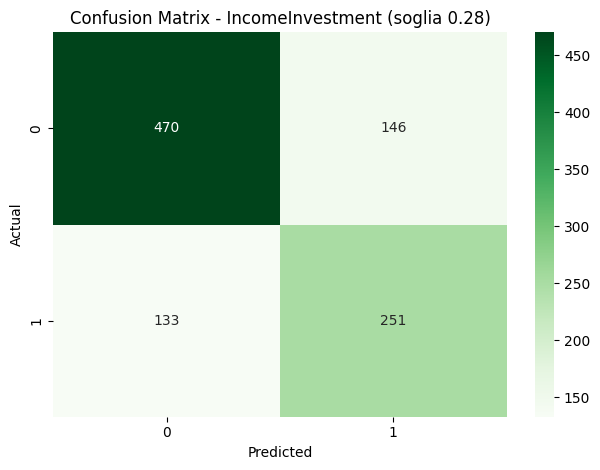

              precision    recall  f1-score   support

           0      0.779     0.763     0.771       616
           1      0.632     0.654     0.643       384

    accuracy                          0.721      1000
   macro avg      0.706     0.708     0.707      1000
weighted avg      0.723     0.721     0.722      1000



In [21]:
# ⚙️ FEATURE ENGINEERING
def prepare_features(df):
    X = df.copy()
    X['Wealth_log'] = np.log1p(X['Wealth'])
    X['Income_log'] = np.log1p(X['Income '])
    X['Income_Wealth_Ratio'] = X['Income '] / X['Wealth'].replace(0, np.nan)
    X['Income_Wealth_Ratio_log'] = np.log1p(X['Income_Wealth_Ratio'].fillna(X['Income '].max()))
    X['Is_Single'] = (X['FamilyMembers'] == 1).astype(int)
    X['Is_Senior'] = (X['Age'] > 65).astype(int)
    X['Has_Education'] = (X['FinancialEducation'] > 0).astype(int)
    X['Risk_Age_Interaction'] = X['RiskPropensity'] * X['Age']

    features = ['Age', 'Gender', 'FamilyMembers', 'FinancialEducation',
                'RiskPropensity', 'Wealth_log', 'Income_log',
                'Income_Wealth_Ratio_log', 'Is_Single', 'Is_Senior',
                'Has_Education', 'Risk_Age_Interaction']

    scaler = MinMaxScaler()
    return pd.DataFrame(scaler.fit_transform(X[features]), columns=features)

# ⚖️ Bilanciamento per XGBoost
def get_scale_pos_weight(y):
    return (y == 0).sum() / (y == 1).sum()

# 🧠 DATI
X = prepare_features(needs_df)
y_inc = needs_df['IncomeInvestment']
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X, y_inc, test_size=0.2, random_state=42, stratify=y_inc)

# 🧩 MODELLI
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                    scale_pos_weight=get_scale_pos_weight(y_train_i), random_state=42)
mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=300, random_state=42)

# ✅ VotingClassifier
voting_inc = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb), ('mlp', mlp)],
    voting='soft'
)

# 🏋️‍♂️ TRAINING
voting_inc.fit(X_train_i, y_train_i)

# 🔮 PREDICT con SOGLIA PERSONALIZZATA
probs = voting_inc.predict_proba(X_test_i)
probs_class1 = probs[:, 1]
threshold = 0.28
y_pred_inc = (probs_class1 >= threshold).astype(int)

# 🎯 METRICHE
f1_inc = f1_score(y_test_i, y_pred_inc, pos_label=1)
print(f"F1-score Income (class 1) con soglia {threshold}: {f1_inc:.3f}")

# 📊 CONFUSION MATRIX
sns.heatmap(confusion_matrix(y_test_i, y_pred_inc), annot=True, fmt='d', cmap='Greens')
plt.title(f"Confusion Matrix - IncomeInvestment (soglia {threshold})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# 📄 REPORT
print(classification_report(y_test_i, y_pred_inc, digits=3))


STACKING CLASSIFIER


🏦 StackingClassifier - IncomeInvestment (recall ≥ 0.70)
✓ Best threshold with recall ≥ 0.70: 0.213 → F1 = 0.603

📄 Classification Report - IncomeInvestment
              precision    recall  f1-score   support

           0      0.768     0.596     0.671       616
           1      0.523     0.711     0.603       384

    accuracy                          0.640      1000
   macro avg      0.645     0.653     0.637      1000
weighted avg      0.674     0.640     0.645      1000



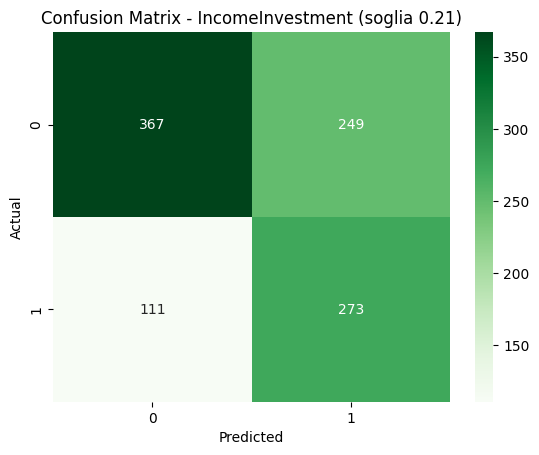


💰 StackingClassifier - AccumulationInvestment
✓ Best threshold = 0.486, F1 = 0.823

📄 Classification Report - AccumulationInvestment
              precision    recall  f1-score   support

           0      0.795     0.867     0.829       487
           1      0.861     0.788     0.823       513

    accuracy                          0.826      1000
   macro avg      0.828     0.827     0.826      1000
weighted avg      0.829     0.826     0.826      1000



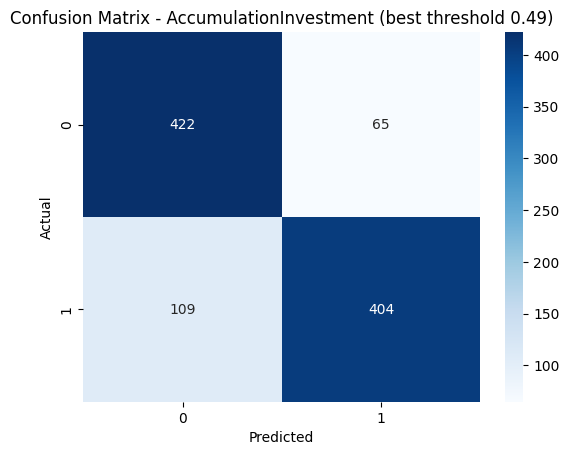

In [22]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler

import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler

import ipywidgets as widgets
from ipywidgets import Layout
from IPython.display import display, clear_output

# ⚖️ Calcolo scale_pos_weight
def get_scale_pos_weight(y):
    return (y == 0).sum() / (y == 1).sum()

# 🔍 Funzione per trovare la soglia ottimale F1
def find_best_threshold(y_true, probs, verbose=True):
    best_f1 = 0
    best_thresh = 0.5
    for t in np.linspace(0.05, 0.95, 100):
        preds = (probs >= t).astype(int)
        f1 = f1_score(y_true, preds, pos_label=1)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = t
    if verbose:
        print(f"✓ Best threshold = {best_thresh:.3f}, F1 = {best_f1:.3f}")
    return best_thresh, best_f1

# 🧠 Prepara i dati
y_income = needs_df['IncomeInvestment']
y_accum  = needs_df['AccumulationInvestment']

X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X, y_income, test_size=0.2, random_state=42, stratify=y_income)
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X, y_accum, test_size=0.2, random_state=42, stratify=y_accum)

# 🧱 Modelli base
def make_stack_model(y_train):
    rf  = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                        scale_pos_weight=get_scale_pos_weight(y_train), random_state=42)
    svm = SVC(probability=True, class_weight='balanced', random_state=42)
    base_learners = [('rf', rf), ('xgb', xgb), ('svm', svm)]
    meta = LogisticRegression(max_iter=1000)
    return StackingClassifier(estimators=base_learners, final_estimator=meta, cv=5)

# 🔍 Ottimizzazione soglia: recall >= 0.7, massimizza F1
def find_threshold_recall_constrained(y_true, probs, min_recall=0.7, verbose=True):
    best_f1 = 0
    best_thresh = None
    for t in np.linspace(0.05, 0.95, 200):
        preds = (probs >= t).astype(int)
        rec = recall_score(y_true, preds, pos_label=1)
        if rec >= min_recall:
            f1 = f1_score(y_true, preds, pos_label=1)
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = t
    if verbose:
        if best_thresh is not None:
            print(f"✓ Best threshold with recall ≥ {min_recall:.2f}: {best_thresh:.3f} → F1 = {best_f1:.3f}")
        else:
            print("⚠️ Nessuna soglia soddisfa il vincolo di recall.")
    return best_thresh, best_f1

# 🏦 StackingClassifier - IncomeInvestment (con vincolo di recall)
from sklearn.metrics import recall_score

print("\n🏦 StackingClassifier - IncomeInvestment (recall ≥ 0.70)")

stack_income = make_stack_model(y_train_i)
stack_income.fit(X_train_i, y_train_i)
probs_i = stack_income.predict_proba(X_test_i)[:, 1]
best_t_i, best_f1_i = find_threshold_recall_constrained(y_test_i, probs_i, min_recall=0.7)

if best_t_i is not None:
    preds_i = (probs_i >= best_t_i).astype(int)

    print("\n📄 Classification Report - IncomeInvestment")
    print(classification_report(y_test_i, preds_i, digits=3))
    sns.heatmap(confusion_matrix(y_test_i, preds_i), annot=True, fmt='d', cmap='Greens')
    plt.title(f"Confusion Matrix - IncomeInvestment (soglia {best_t_i:.2f})")
    plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.show()
else:
    print("⚠️ Nessuna soglia raggiunge recall ≥ 0.70")


# 🔨 AccumulationInvestment
print("\n💰 StackingClassifier - AccumulationInvestment")
stack_accum = make_stack_model(y_train_a)
stack_accum.fit(X_train_a, y_train_a)
probs_a = stack_accum.predict_proba(X_test_a)[:, 1]
best_t_a, _ = find_best_threshold(y_test_a, probs_a)
preds_a = (probs_a >= best_t_a).astype(int)

print("\n📄 Classification Report - AccumulationInvestment")
print(classification_report(y_test_a, preds_a, digits=3))
sns.heatmap(confusion_matrix(y_test_a, preds_a), annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix - AccumulationInvestment (best threshold {best_t_a:.2f})")
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.show()


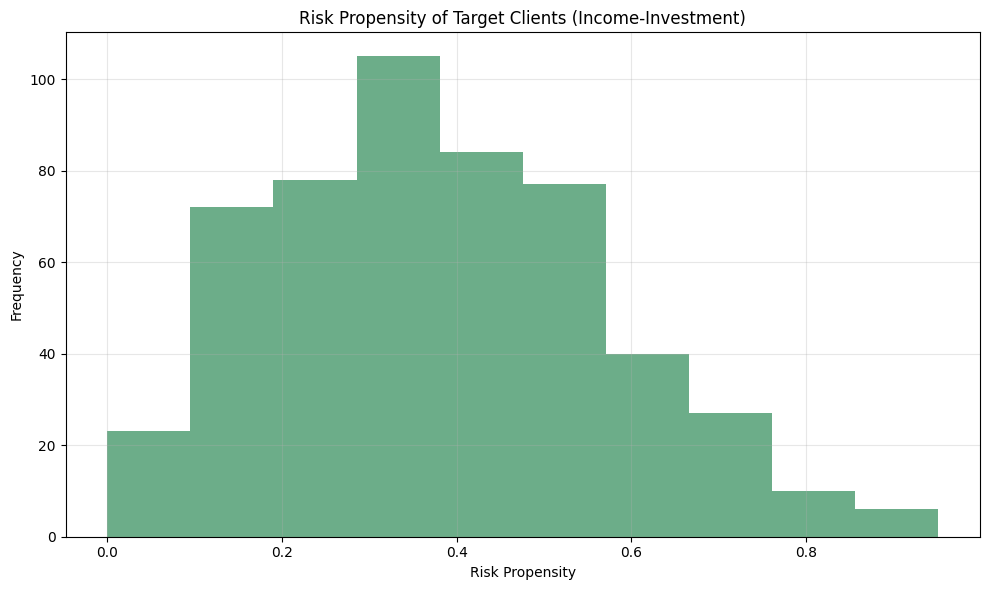


📊 Recommendation statistics (Income-Investment):
Total customers analyzed: 522
Customers with valid recommendations: 499 (95.59%)
Customers without suitable recommendations: 23


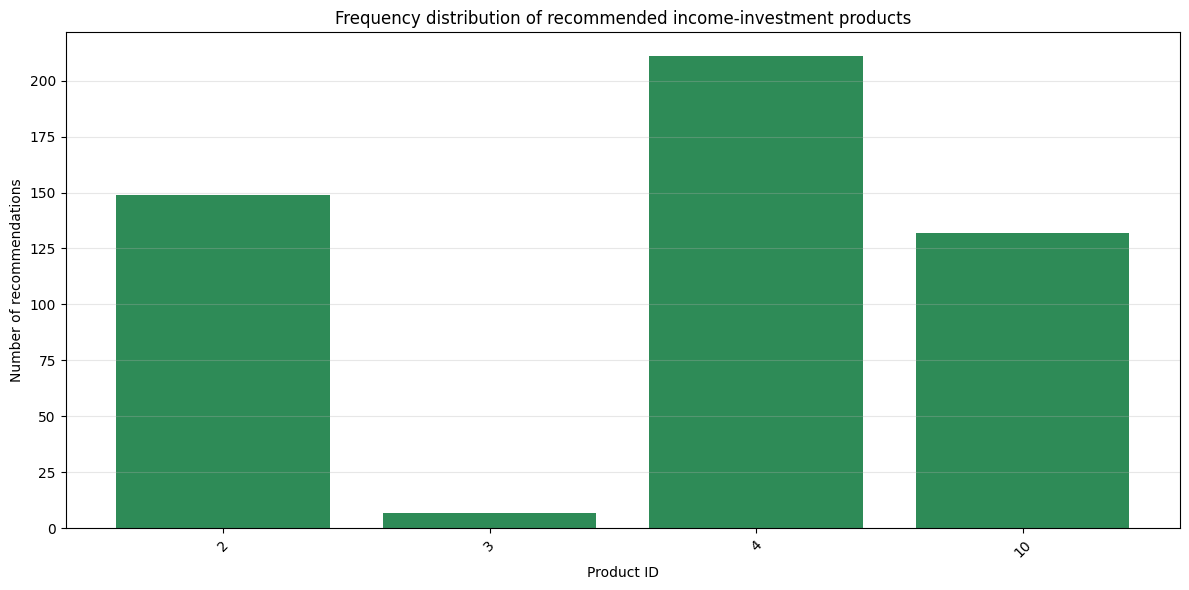


🏅 Top 3 recommended income-investment products:

🔹 Product ID: 4
Name: Balanced High Dividend Mutual Fund
Risk: 0.44
Recommended to 211 clients

🔹 Product ID: 2
Name: Income Conservative Unit-Linked (Life Insurance)
Risk: 0.3
Recommended to 149 clients

🔹 Product ID: 10
Name: Fixed Income Segregated Account
Risk: 0.13
Recommended to 132 clients


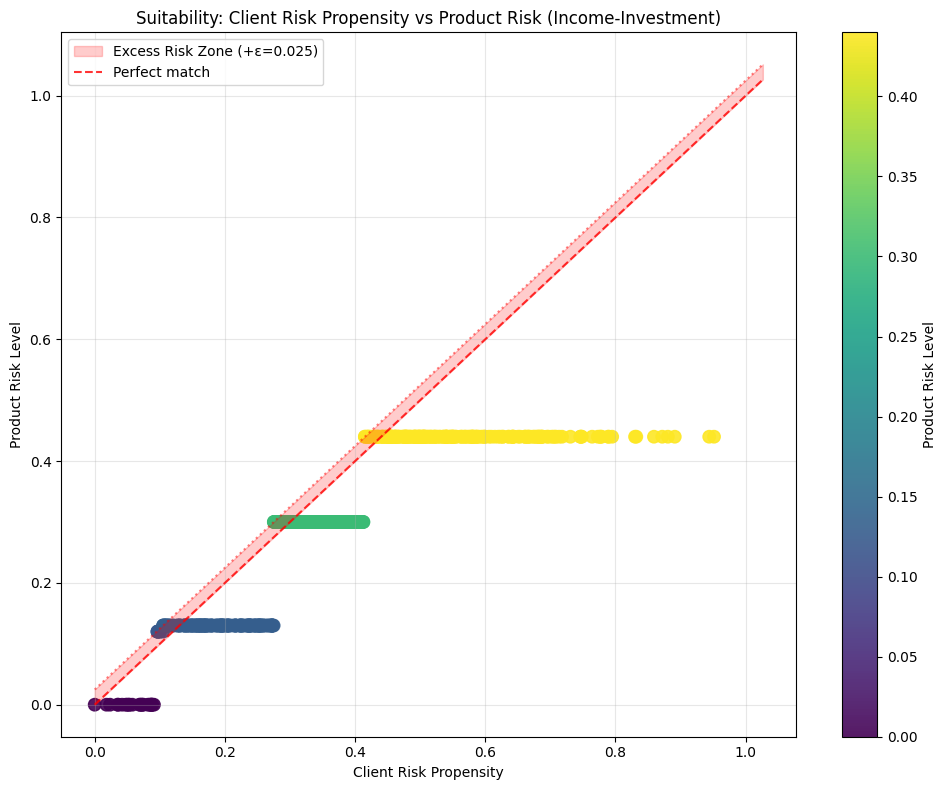

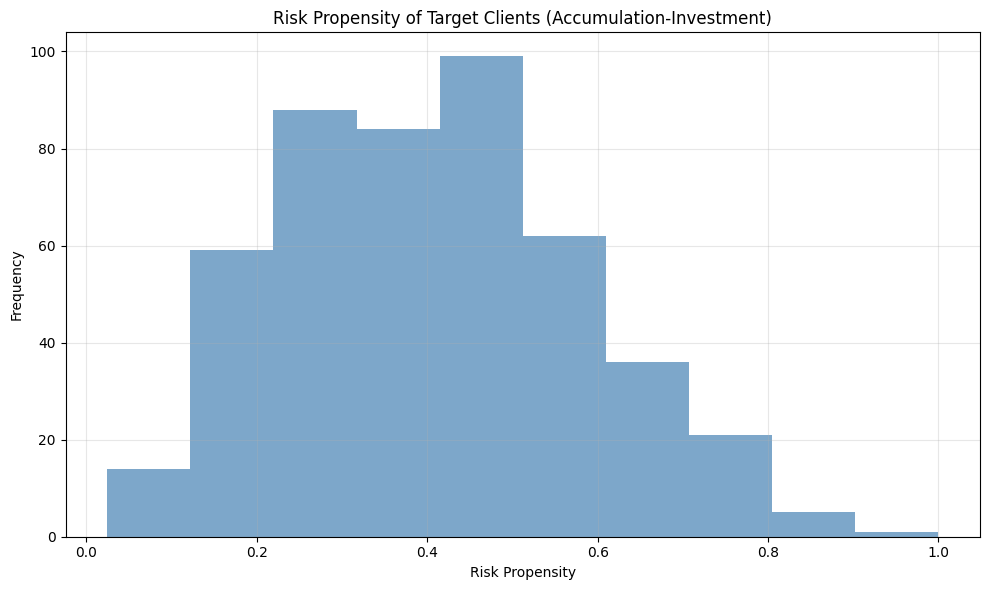


📊 Recommendation statistics (Accumulation-Investment):
Total customers analyzed: 469
Customers with valid recommendations: 375 (79.96%)
Customers without suitable recommendations: 94


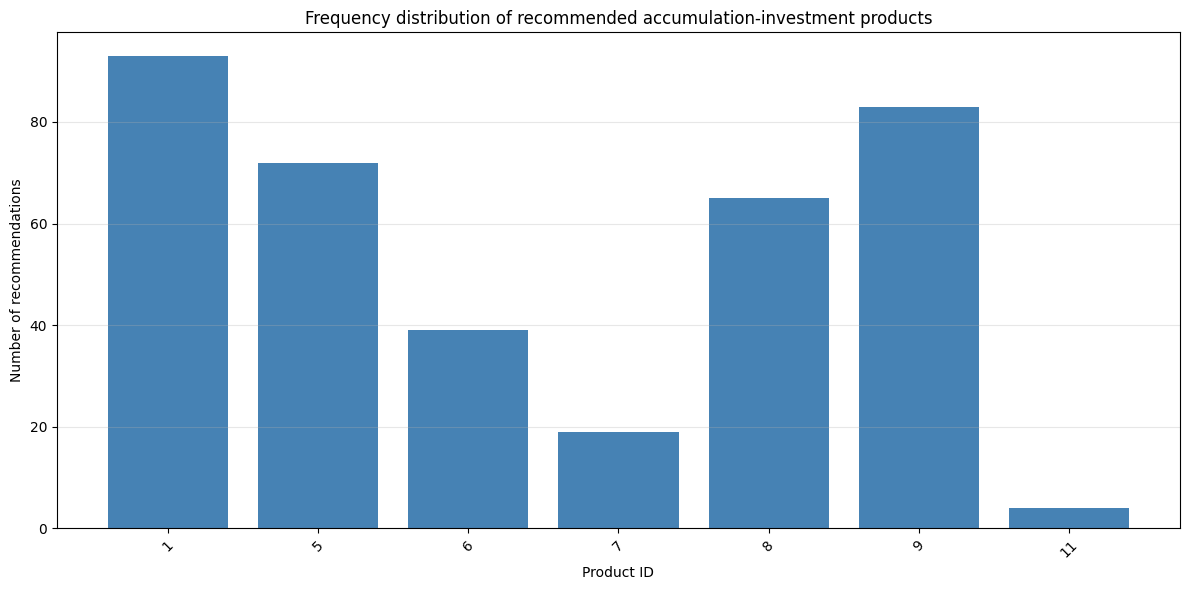


🏅 Top 3 recommended accumulation-investment products:

🔹 Product ID: 1
Name: Balanced Mutual Fund
Risk: 0.55
Recommended to 93 clients

🔹 Product ID: 9
Name: Cautious Allocation Segregated Account
Risk: 0.27
Recommended to 83 clients

🔹 Product ID: 5
Name: Balanced Mutual Fund
Risk: 0.41
Recommended to 72 clients


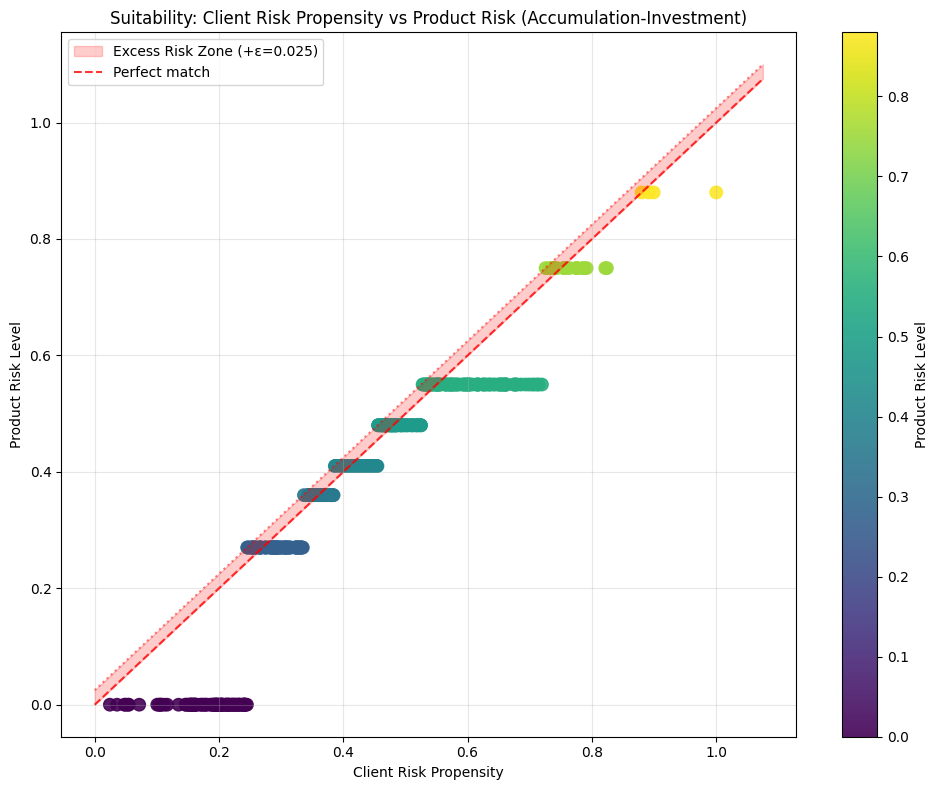

In [23]:
# 🧠 Mappa ID → ProductName
product_name_map = {
    1: "Balanced Mutual Fund",
    2: "Income Conservative Unit-Linked (Life Insurance)",
    3: "Fixed Income Mutual Fund",
    4: "Balanced High Dividend Mutual Fund",
    5: "Balanced Mutual Fund",
    6: "Defensive Flexible Allocation Unit-Linked (Life Insurance)",
    7: "Aggressive Flexible Allocation Unit-Linked (Life Insurance)",
    8: "Balanced Flexible Allocation Unit-Linked (Life Insurance)",
    9: "Cautious Allocation Segregated Account",
    10: "Fixed Income Segregated Account",
    11: "Total Return Aggressive Allocation Segregated Account"
}
products_df['ProductName'] = products_df['IDProduct'].map(product_name_map)

# ⚙️ Funzione raccomandazione
def build_nba_df(y_pred, X_test, product_type_label, epsilon=0.05):
    client_indices = np.where(y_pred == 1)[0]
    client_ids = needs_df.iloc[X_test.index[client_indices]].index.values
    client_risks = X_test.iloc[client_indices]['RiskPropensity'].values

    product_pool = products_df[products_df['Type'] == product_type_label].copy()
    nba_records = []

    for cid, crisk in zip(client_ids, client_risks):
        max_risk = crisk + epsilon
        suitable = product_pool[product_pool['Risk'] <= max_risk]
        if not suitable.empty:
            best_product = suitable.loc[suitable['Risk'].idxmax()]
            nba_records.append({
                'ClientID': cid,
                'ClientRiskPropensity': crisk,
                'RecommendedProductID': best_product['IDProduct'],
                'ProductRiskLevel': best_product['Risk'],
                'ProductName': best_product['ProductName']
            })
        else:
            nba_records.append({
                'ClientID': cid,
                'ClientRiskPropensity': crisk,
                'RecommendedProductID': 0,
                'ProductRiskLevel': 0,
                'ProductName': 'N/A'
            })

    return pd.DataFrame(nba_records)

# 📊 Analisi
def plot_recommendation_analysis(nba_df, label, epsilon=0.05, color='#4682B4'):
    import matplotlib.pyplot as plt
    import numpy as np

    plt.figure(figsize=(10, 6))
    plt.hist(nba_df['ClientRiskPropensity'], bins=10, color=color, alpha=0.7)
    plt.title(f'Risk Propensity of Target Clients ({label})')
    plt.xlabel('Risk Propensity')
    plt.ylabel('Frequency')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    total = len(nba_df)
    valid = (nba_df['RecommendedProductID'] > 0).sum()
    print(f"\n📊 Recommendation statistics ({label}):")
    print(f"Total customers analyzed: {total}")
    print(f"Customers with valid recommendations: {valid} ({100 * valid / total:.2f}%)")
    print(f"Customers without suitable recommendations: {total - valid}")

    if valid > 0:
        plt.figure(figsize=(12, 6))
        counts = nba_df[nba_df['RecommendedProductID'] > 0]['RecommendedProductID'].value_counts().sort_index()
        plt.bar(counts.index.astype(str), counts.values, color=color)
        plt.title(f'Frequency distribution of recommended {label.lower()} products')
        plt.xlabel('Product ID')
        plt.ylabel('Number of recommendations')
        plt.xticks(rotation=45)
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()

        top3 = counts.nlargest(3).index
        print(f"\n🏅 Top 3 recommended {label.lower()} products:")
        for pid in top3:
            row = products_df[products_df['IDProduct'] == pid].iloc[0]
            print(f"\n🔹 Product ID: {pid}")
            print(f"Name: {row['ProductName']}")
            print(f"Risk: {row['Risk']}")
            print(f"Recommended to {counts[pid]} clients")

    plt.figure(figsize=(10, 8))
    sc = plt.scatter(nba_df['ClientRiskPropensity'], nba_df['ProductRiskLevel'],
                     c=nba_df['ProductRiskLevel'], cmap='viridis', s=80, alpha=0.9)
    max_val = max(nba_df['ClientRiskPropensity'].max(), nba_df['ProductRiskLevel'].max()) + epsilon + 0.05
    x_vals = np.linspace(0, max_val, 500)
    plt.fill_between(x_vals, x_vals, x_vals + epsilon, color='red', alpha=0.2, label=f'Excess Risk Zone (+ε={epsilon})')
    plt.plot(x_vals, x_vals, 'r--', label='Perfect match', alpha=0.8)
    plt.plot(x_vals, x_vals + epsilon, 'r:', alpha=0.5)
    plt.colorbar(sc, label='Product Risk Level')
    plt.title(f'Suitability: Client Risk Propensity vs Product Risk ({label})')
    plt.xlabel('Client Risk Propensity')
    plt.ylabel('Product Risk Level')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# 🧾 Costruisci e visualizza
epsilon = 0.025
nba_income = build_nba_df(preds_i, X_test_i, product_type_label=0, epsilon=epsilon)
nba_accum  = build_nba_df(preds_a, X_test_a, product_type_label=1, epsilon=epsilon)

plot_recommendation_analysis(nba_income, 'Income-Investment', epsilon=epsilon, color='#2E8B57')
plot_recommendation_analysis(nba_accum,  'Accumulation-Investment', epsilon=epsilon, color='#4682B4')


In [24]:
# ————————————————
# 1) `products_df` è già caricato più sopra
# ————————————————

# Aggiunta "brute-force" dei 5 prodotti extra
new_products = pd.DataFrame({
    'IDProduct': [12, 13, 14, 15, 16],
    'Type':       [0,   0,  1,  1,  0],
    'Risk':       [0.55,0.70,0.70,0.15,0.85]
})
products_df = pd.concat([products_df, new_products], ignore_index=True)

# Rimuovi eventuali righe con Risk == 0.12
products_df = products_df.loc[products_df['Risk'] != 0.12]

# Verifica
print("Products:", products_df.shape)



Products: (15, 4)


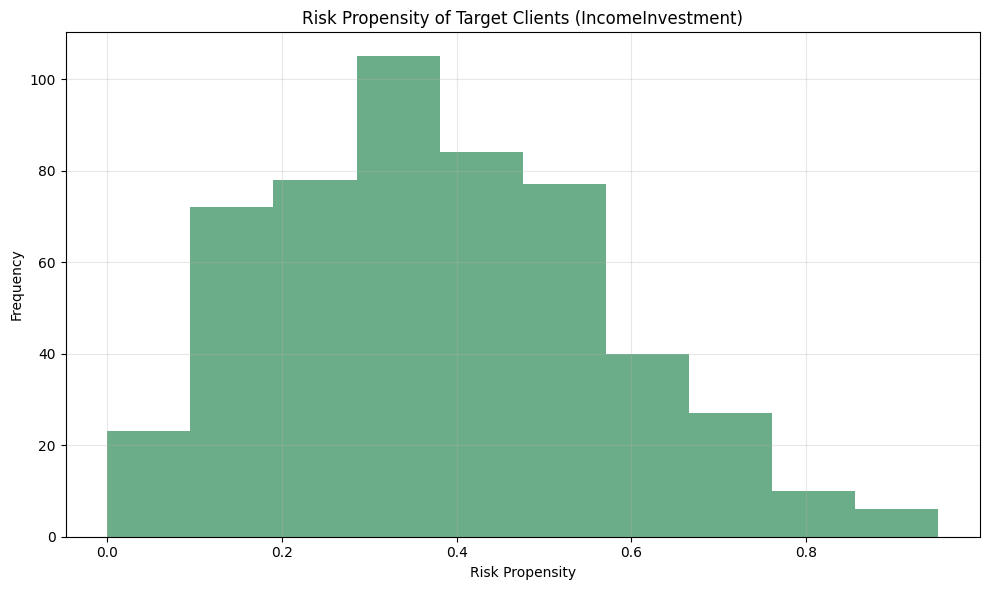


📊 Recommendation statistics (IncomeInvestment):
Total customers analyzed: 522
Customers with valid recommendations: 492 (94.25%)
Customers without suitable recommendations: 30


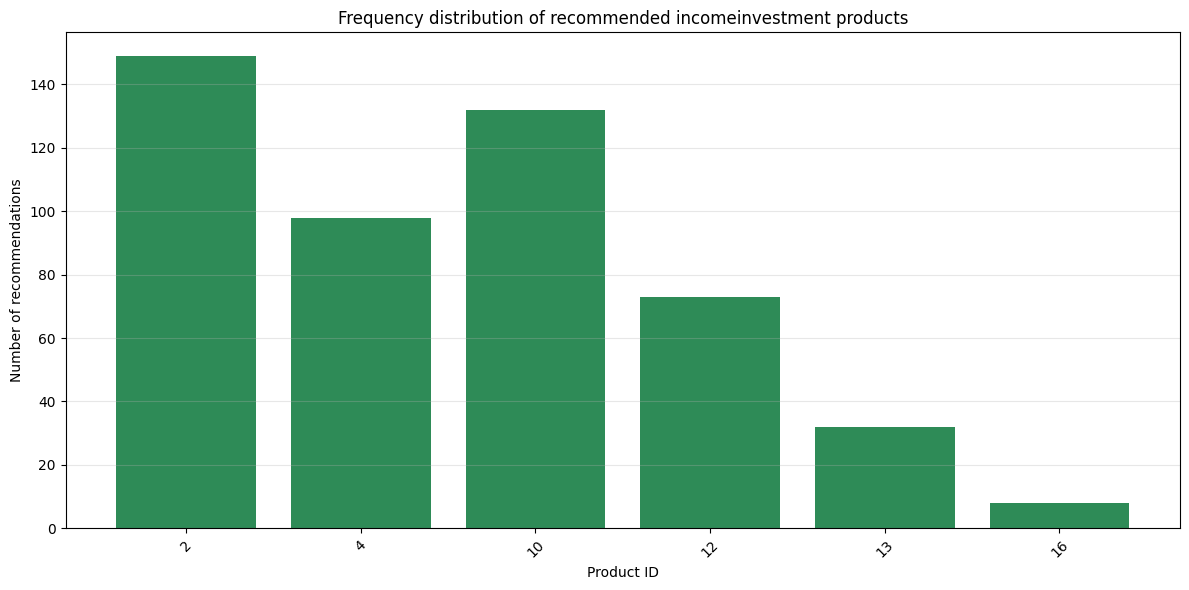


🏅 Top 3 recommended incomeinvestment products:

🔹 Product ID: 2
Name: Income Conservative Unit-Linked (Life Insurance)
Risk: 0.3
Recommended to 149 clients

🔹 Product ID: 10
Name: Fixed Income Segregated Account
Risk: 0.13
Recommended to 132 clients

🔹 Product ID: 4
Name: Balanced High Dividend Mutual Fund
Risk: 0.44
Recommended to 98 clients


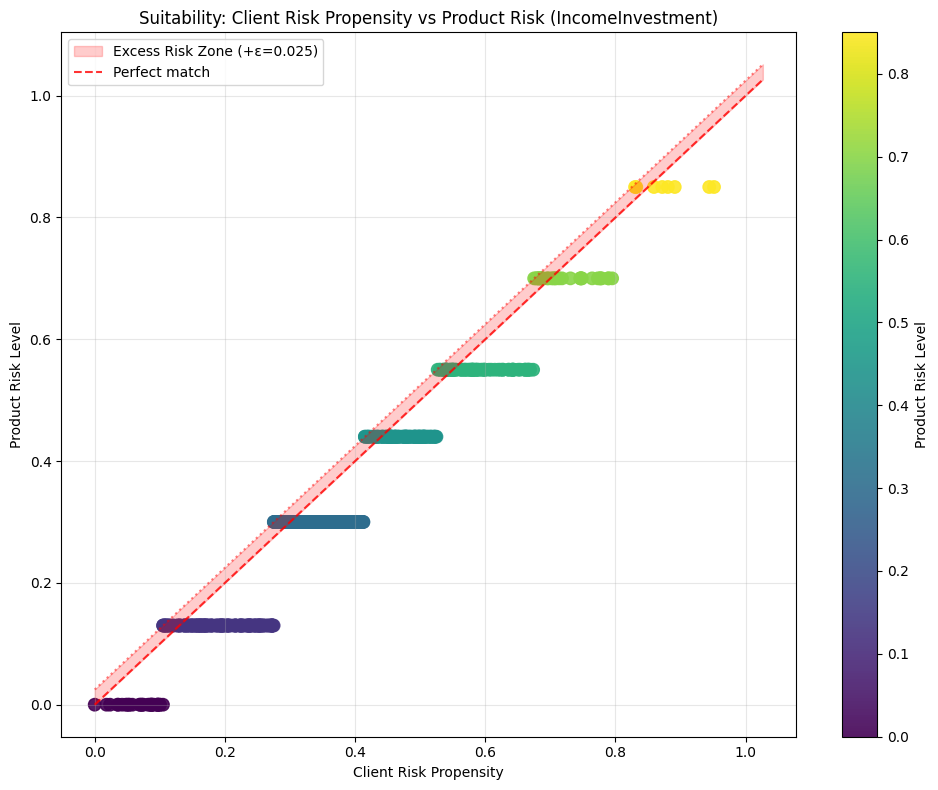

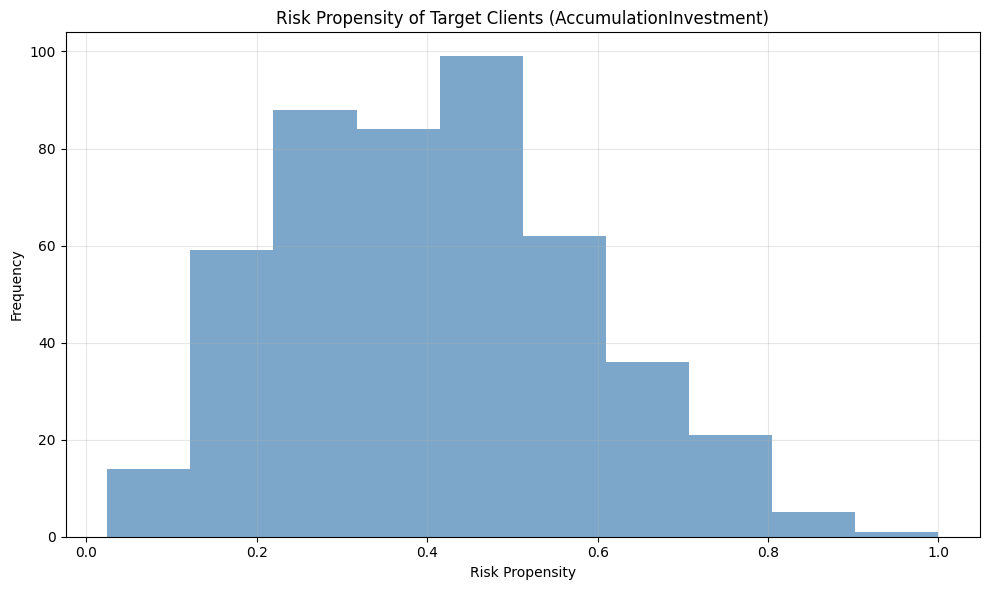


📊 Recommendation statistics (AccumulationInvestment):
Total customers analyzed: 469
Customers with valid recommendations: 455 (97.01%)
Customers without suitable recommendations: 14


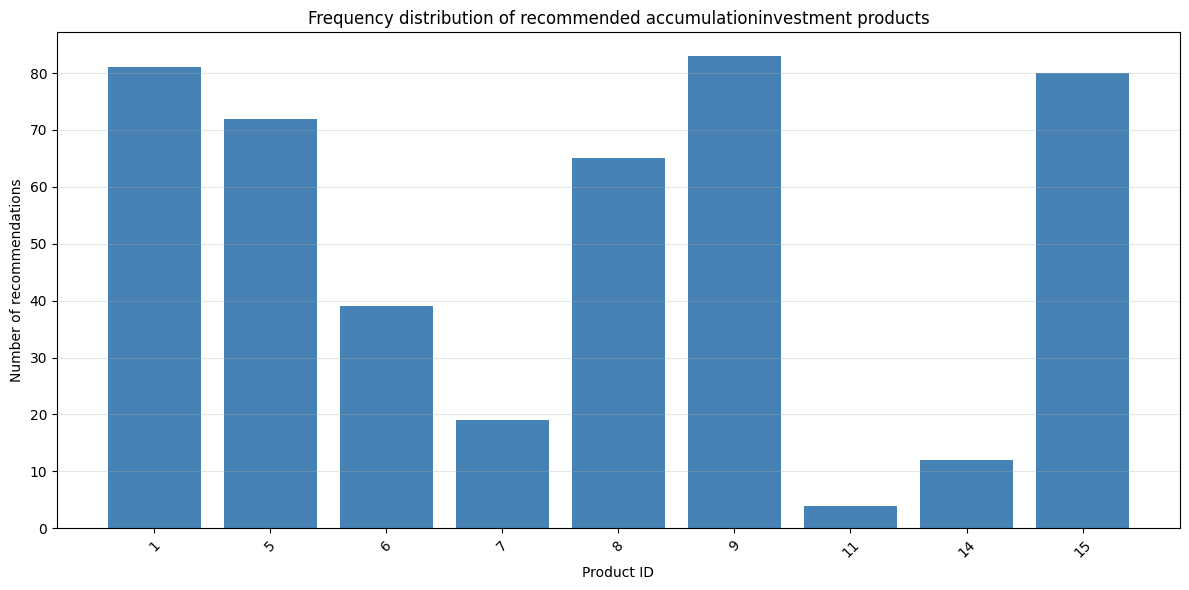


🏅 Top 3 recommended accumulationinvestment products:

🔹 Product ID: 9
Name: Cautious Allocation Segregated Account
Risk: 0.27
Recommended to 83 clients

🔹 Product ID: 1
Name: Balanced Mutual Fund
Risk: 0.55
Recommended to 81 clients

🔹 Product ID: 15
Name: Short-Term Government Bond Accumulation Fund
Risk: 0.15
Recommended to 80 clients


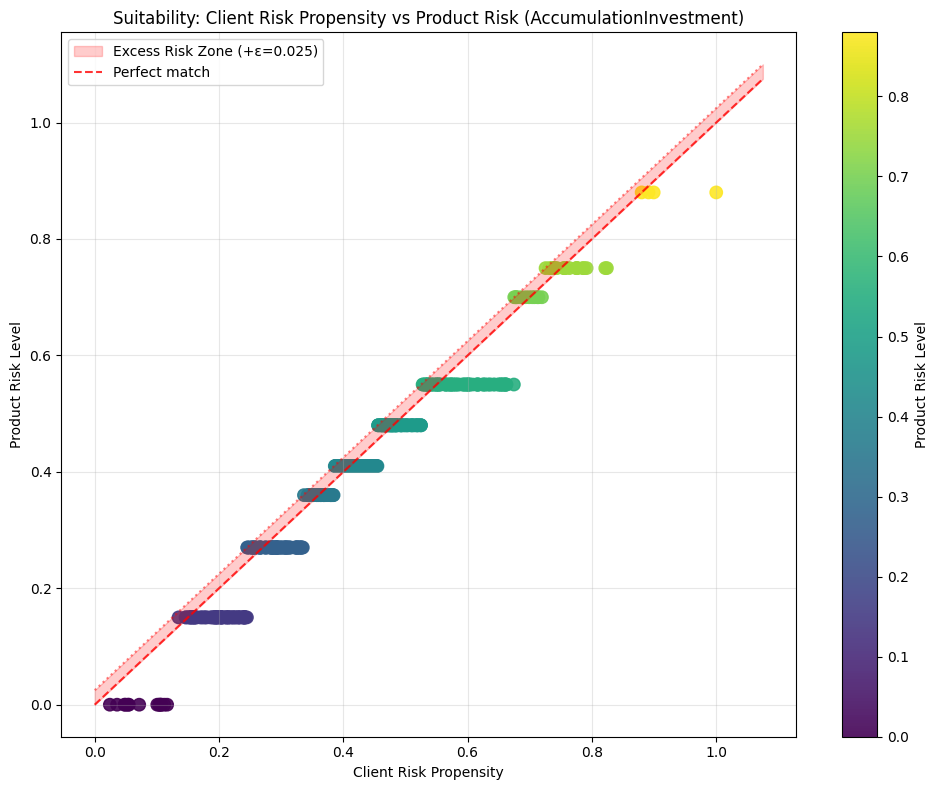

In [25]:
# 🧠 Mappa ID → ProductName
product_name_map = {
    1: "Balanced Mutual Fund",
    2: "Income Conservative Unit-Linked (Life Insurance)",
    3: "Fixed Income Mutual Fund",
    4: "Balanced High Dividend Mutual Fund",
    5: "Balanced Mutual Fund",
    6: "Defensive Flexible Allocation Unit-Linked (Life Insurance)",
    7: "Aggressive Flexible Allocation Unit-Linked (Life Insurance)",
    8: "Balanced Flexible Allocation Unit-Linked (Life Insurance)",
    9: "Cautious Allocation Segregated Account",
    10: "Fixed Income Segregated Account",
    11: "Total Return Aggressive Allocation Segregated Account",
    12:	"Global Diversified Income Fund",
    13:	"Emerging Markets High Yield Bond Fund",
    14:	"Sustainable Growth Equity Portfolio",
    15:	"Short-Term Government Bond Accumulation Fund",
    16:	"Tranche Equity CDO"
}
products_df['ProductName'] = products_df['IDProduct'].map(product_name_map)

# ⚙️ Funzione raccomandazione
def build_nba_df(y_pred, X_test, product_type_label, epsilon=0.05):
    client_indices = np.where(y_pred == 1)[0]
    client_ids = needs_df.iloc[X_test.index[client_indices]].index.values
    client_risks = X_test.iloc[client_indices]['RiskPropensity'].values

    product_pool = products_df[products_df['Type'] == product_type_label].copy()
    nba_records = []

    for cid, crisk in zip(client_ids, client_risks):
        max_risk = crisk + epsilon
        suitable = product_pool[product_pool['Risk'] <= max_risk]
        if not suitable.empty:
            best_product = suitable.loc[suitable['Risk'].idxmax()]
            nba_records.append({
                'ClientID': cid,
                'ClientRiskPropensity': crisk,
                'RecommendedProductID': best_product['IDProduct'],
                'ProductRiskLevel': best_product['Risk'],
                'ProductName': best_product['ProductName']
            })
        else:
            nba_records.append({
                'ClientID': cid,
                'ClientRiskPropensity': crisk,
                'RecommendedProductID': 0,
                'ProductRiskLevel': 0,
                'ProductName': 'N/A'
            })

    return pd.DataFrame(nba_records)

# 📊 Analisi
def plot_recommendation_analysis(nba_df, label, epsilon=0.05, color='#4682B4'):
    import matplotlib.pyplot as plt
    import numpy as np

    plt.figure(figsize=(10, 6))
    plt.hist(nba_df['ClientRiskPropensity'], bins=10, color=color, alpha=0.7)
    plt.title(f'Risk Propensity of Target Clients ({label})')
    plt.xlabel('Risk Propensity')
    plt.ylabel('Frequency')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    total = len(nba_df)
    valid = (nba_df['RecommendedProductID'] > 0).sum()
    print(f"\n📊 Recommendation statistics ({label}):")
    print(f"Total customers analyzed: {total}")
    print(f"Customers with valid recommendations: {valid} ({100 * valid / total:.2f}%)")
    print(f"Customers without suitable recommendations: {total - valid}")

    if valid > 0:
        plt.figure(figsize=(12, 6))
        counts = nba_df[nba_df['RecommendedProductID'] > 0]['RecommendedProductID'].value_counts().sort_index()
        plt.bar(counts.index.astype(str), counts.values, color=color)
        plt.title(f'Frequency distribution of recommended {label.lower()} products')
        plt.xlabel('Product ID')
        plt.ylabel('Number of recommendations')
        plt.xticks(rotation=45)
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()

        top3 = counts.nlargest(3).index
        print(f"\n🏅 Top 3 recommended {label.lower()} products:")
        for pid in top3:
            row = products_df[products_df['IDProduct'] == pid].iloc[0]
            print(f"\n🔹 Product ID: {pid}")
            print(f"Name: {row['ProductName']}")
            print(f"Risk: {row['Risk']}")
            print(f"Recommended to {counts[pid]} clients")

    plt.figure(figsize=(10, 8))
    sc = plt.scatter(nba_df['ClientRiskPropensity'], nba_df['ProductRiskLevel'],
                     c=nba_df['ProductRiskLevel'], cmap='viridis', s=80, alpha=0.9)
    max_val = max(nba_df['ClientRiskPropensity'].max(), nba_df['ProductRiskLevel'].max()) + epsilon + 0.05
    x_vals = np.linspace(0, max_val, 500)
    plt.fill_between(x_vals, x_vals, x_vals + epsilon, color='red', alpha=0.2, label=f'Excess Risk Zone (+ε={epsilon})')
    plt.plot(x_vals, x_vals, 'r--', label='Perfect match', alpha=0.8)
    plt.plot(x_vals, x_vals + epsilon, 'r:', alpha=0.5)
    plt.colorbar(sc, label='Product Risk Level')
    plt.title(f'Suitability: Client Risk Propensity vs Product Risk ({label})')
    plt.xlabel('Client Risk Propensity')
    plt.ylabel('Product Risk Level')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# 🧾 Costruisci e visualizza
epsilon = 0.025
nba_income = build_nba_df(preds_i, X_test_i, product_type_label=0, epsilon=epsilon)
nba_accum  = build_nba_df(preds_a, X_test_a, product_type_label=1, epsilon=epsilon)

plot_recommendation_analysis(nba_income, 'IncomeInvestment', epsilon=epsilon, color='#2E8B57')
plot_recommendation_analysis(nba_accum,  'AccumulationInvestment', epsilon=epsilon, color='#4682B4')


RISK PROPENSITY PREDICTION + MANUAL FEATURE = RECOMMENDATION PROCESS

In [26]:
# ⚠️ Assicurati che needs_df e products_df siano già caricati

# 🔁 Modello per stimare RiskPropensity (usato solo nel widget)
risk_model = XGBRegressor()
risk_model.fit(needs_df[['Age', 'Gender', 'FamilyMembers', 'FinancialEducation', 'Income ', 'Wealth']],
               needs_df['RiskPropensity'])

# 🧠 Funzione di feature engineering coerente con il tuo modello
def feature_engineering(input_dict):
    income_val = input_dict['Income']
    wealth_val = input_dict['Wealth']
    risk_val = input_dict['RiskPropensity']
    age_val = input_dict['Age']
    family_members = input_dict['FamilyMembers']
    edu = input_dict['FinancialEducation']

    features = {
        "Age": age_val,
        "Gender": input_dict['Gender'],
        "FamilyMembers": family_members,
        "FinancialEducation": edu,
        "RiskPropensity": risk_val,
        "Wealth_log": np.log1p(wealth_val),
        "Income_log": np.log1p(income_val),
        "Income_Wealth_Ratio_log": np.log1p(income_val / wealth_val) if wealth_val != 0 else np.log1p(income_val),
        "Is_Single": int(family_members == 1),
        "Is_Senior": int(age_val > 65),
        "Has_Education": int(edu > 0.1),
        "Risk_Age_Interaction": risk_val * age_val
    }

    return pd.DataFrame([features])

# 📊 Sistema di raccomandazione
def recommend_products(input_data, epsilon=0.05):
    feats = feature_engineering(input_data)
    prob_i = stack_income.predict_proba(feats)[0, 1]
    prob_a = stack_accum.predict_proba(feats)[0, 1]


    pred_i = int(prob_i >= best_t_i)
    pred_a = int(prob_a >= best_t_a)

    results = []

    if pred_i == 1:
        client_risk = feats['RiskPropensity'].iloc[0]
        suitable = products_df[(products_df['Type'] == 0) & (products_df['Risk'] <= client_risk + epsilon)]
        if not suitable.empty:
            best_product = suitable.loc[suitable['Risk'].idxmax()]
            results.append({
                "InvestmentType": "Income",
                "RecommendedProductID": int(best_product['IDProduct']),
                "ProductName": best_product['ProductName'],
                "ProductRisk": best_product['Risk'],
                "PredictedProb": round(prob_i, 3)
            })

    if pred_a == 1:
        client_risk = feats['RiskPropensity'].iloc[0]
        suitable = products_df[(products_df['Type'] == 1) & (products_df['Risk'] <= client_risk + epsilon)]
        if not suitable.empty:
            best_product = suitable.loc[suitable['Risk'].idxmax()]
            results.append({
                "InvestmentType": "Accumulation",
                "RecommendedProductID": int(best_product['IDProduct']),
                "ProductName": best_product['ProductName'],
                "ProductRisk": best_product['Risk'],
                "PredictedProb": round(prob_a, 3)
            })

    if not results:
        results.append({
            "InvestmentType": "None",
            "RecommendedProductID": 0,
            "ProductName": "No Investment Needed",
            "ProductRisk": "-",
            "PredictedProb": "-"
        })

    return pd.DataFrame(results)



# 🧩 Widget interattivo
def launch_widget():
    age = widgets.IntSlider(value=35, min=18, max=90, description='Age:')
    gender = widgets.Dropdown(options=[('Male', 0), ('Female', 1)], value=0, description='Gender:')
    family = widgets.IntSlider(value=2, min=1, max=10, description='Family:')
    education = widgets.FloatSlider(value=0.5, min=0, max=1, step=0.01, description='Education:')
    income = widgets.FloatSlider(value=60, min=5, max=250, step=1.0, description='Income:')
    wealth = widgets.FloatSlider(value=80, min=5, max=1000, step=1.0, description='Wealth:')
    button = widgets.Button(description="Get Recommendation")

    ui = widgets.VBox([age, gender, family, education, income, wealth, button])

    def on_click(b):
        clear_output(wait=True)
        display(ui)

        user_input = {
            "Age": age.value,
            "Gender": gender.value,
            "FamilyMembers": family.value,
            "FinancialEducation": education.value,
            "Income": income.value,
            "Wealth": wealth.value
        }

        # 🔍 Predizione RiskPropensity
        X_risk = pd.DataFrame([user_input])
        X_risk.columns = ['Age', 'Gender', 'FamilyMembers', 'FinancialEducation', 'Income ', 'Wealth']
        user_input['RiskPropensity'] = float(risk_model.predict(X_risk)[0])

        print(f"\n📊 Predicted Risk Propensity: {user_input['RiskPropensity']:.3f}")

        # 🎯 Raccomandazioni
        recommendation = recommend_products(user_input)
        display(recommendation)

    button.on_click(on_click)
    display(ui)

# ▶️ Avvia
launch_widget()


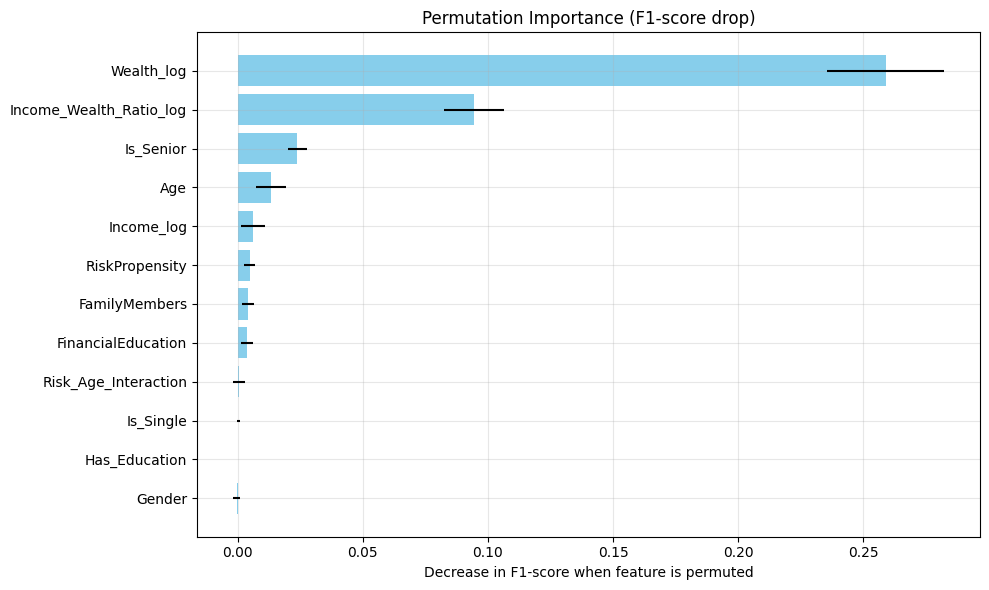

,Feature,Importance Mean,Importance Std
0,Wealth_log,0.258868,0.023490
1,Income_Wealth_Ratio_log,0.094431,0.011789
2,Is_Senior,0.023812,0.003753
3,Age,0.013196,0.005942
4,Income_log,0.006232,0.004838
5,RiskPropensity,0.004817,0.002166
6,FamilyMembers,0.004169,0.002549
7,FinancialEducation,0.003851,0.002396
8,Risk_Age_Interaction,0.000412,0.002439
9,Is_Single,0.000213,0.000640


In [27]:
# ✅ Scegli il modello e i dati (Income o Accumulation)
model = stack_income  # oppure stack_accum
X_eval = X_test_i.copy()  # oppure X_test_a
y_eval = y_test_i.copy()  # oppure y_test_a

# ⚙️ Calcolo Permutation Importance
result = permutation_importance(
    model,
    X_eval,
    y_eval,
    n_repeats=10,
    random_state=42,
    scoring='f1'
)

# 📊 Mostra risultati
importances = pd.DataFrame({
    'Feature': X_eval.columns,
    'Importance Mean': result.importances_mean,
    'Importance Std': result.importances_std
}).sort_values(by='Importance Mean', ascending=False)

# 🔝 Plot
plt.figure(figsize=(10, 6))
plt.barh(importances['Feature'], importances['Importance Mean'], xerr=importances['Importance Std'], color='skyblue')
plt.gca().invert_yaxis()
plt.title("Permutation Importance (F1-score drop)")
plt.xlabel("Decrease in F1-score when feature is permuted")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 📄 (facoltativo) Mostra anche tabella
importances.reset_index(drop=True).head(10)


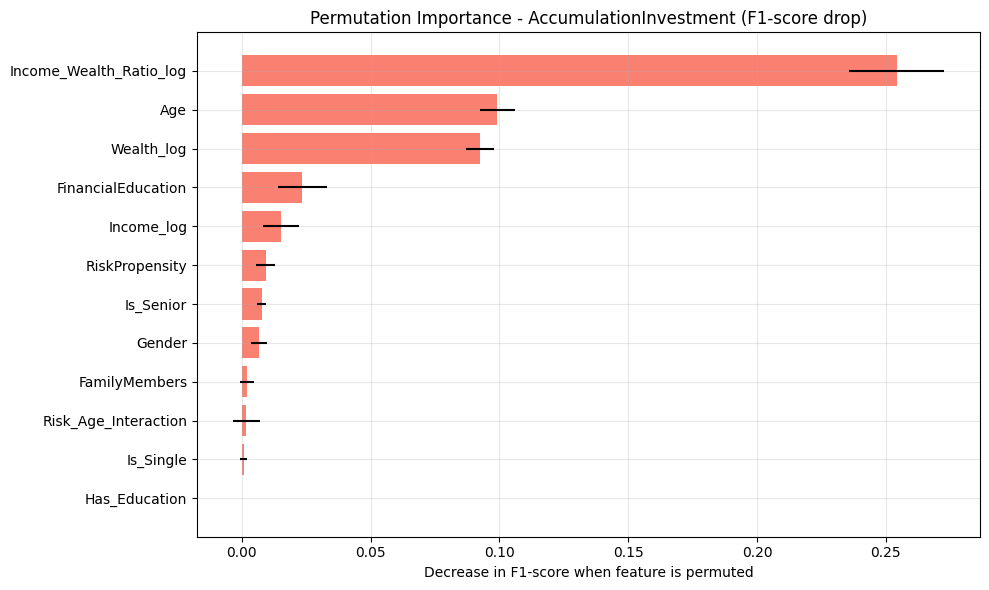

In [28]:
# ✅ 1. Permutation Importance su stack_accum
model = stack_accum
X_eval = X_test_a.copy()
y_eval = y_test_a.copy()

result = permutation_importance(
    model,
    X_eval,
    y_eval,
    n_repeats=10,
    random_state=42,
    scoring='f1'
)

importances = pd.DataFrame({
    'Feature': X_eval.columns,
    'Importance Mean': result.importances_mean,
    'Importance Std': result.importances_std
}).sort_values(by='Importance Mean', ascending=False)

# ✅ 2. Plot delle importanze
plt.figure(figsize=(10, 6))
plt.barh(importances['Feature'], importances['Importance Mean'], xerr=importances['Importance Std'], color='salmon')
plt.gca().invert_yaxis()
plt.title("Permutation Importance - AccumulationInvestment (F1-score drop)")
plt.xlabel("Decrease in F1-score when feature is permuted")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()




PARTE DI ALE:
Unire quello fatto da cami e cecio per predire risk propensity dallo slider con le info del prof con un questionario stile MiFID II.

Faccio domande per stabilire la financial literacy, così da non doverla chiedere tramite slider al cliente.
Poi usiamo algoritmo già fatto da Cami e Cecio per predire risk propensity da quei dati e facciamo media pesata con lo score che esce dal questionario MiFID per la risk propensity.
Infine come prima consigliamo i prodotti adeguati


In [29]:
# ———————————————————————————————————————————
# ⚠️ Assicurati che needs_df, products_df, stack_income, stack_accum,
# best_t_i, best_t_a siano già caricati/pronti
# ———————————————————————————————————————————

# 🔁 Modello per stimare RiskPropensity (usato solo nel widget)
risk_model = XGBRegressor()
risk_model.fit(
    needs_df[['Age', 'Gender', 'FamilyMembers', 'FinancialEducation', 'Income ', 'Wealth']],
    needs_df['RiskPropensity']
)

# 👇 OUTPUT WIDGET GLOBALE
output = widgets.Output()

# 🧩 Definizione domande MiFID II
financial_lit_questions = [
    { 'question': 'What is your education title?',
      'options': { 'No': 0.0, 'High School Diploma': 0.015, 'Bachelor Degree': 0.025,
                   'Bachelor Degree in economic/financial subjects': 0.075,
                   'Master Degree': 0.05, 'Master Degree in economic/financial subjects': 0.1 }
    },
    { 'question': 'Have you worked in the financial industry?',
      'options': {'Yes': 0.1, 'No': 0.0}
    },
    { 'question': 'Flag the most risky financial instruments in which you have invested',
      'options': {'Equity': 0.04, 'Mutual funds/Sicav/ETFs': 0.015, 'Bonds': 0.02,
                  'Government Bonds': 0.015,
                  'Structured Bonds (equity linked, reverse floater, reverse convertible)': 0.06,
                  'Insurance Products': 0.008, 'Covered Warrants/Warrants/Investment Certificates': 0.06,
                  'Portfolio Management': 0.04,
                  'Financial Derivatives (e.g. Options/Swaps/leveraged instruments)': 0.1 }
    },
    { 'question': 'With what frequency did you invest in financial products in the last 5 years?',
      'options': {'More than 10 times a year': 0.1, 'Between 5 and 10': 0.05, 'Less than 5': 0.0}
    },
    { 'question': 'The rating is a score expressed by an independent third party entity that measures?',
      'options': {'The solidity of an enterprise': 0.1, 'The productivity rate of an enterprise': 0.015,
                  'The revenues of a company': 0.0}
    },
    { 'question': 'What is an option?',
      'options': {'It is a financial contract whose value depends on the movements of an underlying asset': 0.1,
                  'An investment contract similar to equity and/or Bonds': 0.06,
                  'An instrument with guaranteed capital': 0.0}
    },
    { 'question': 'What happens to the owners of subordinated bonds in insolvency of the issuer?',
      'options': {'They never get reimbursed': 0.05,
                  'They get reimbursed just after the owners of non-subordinated bonds': 0.1,
                  'They get reimbursed with stocks': 0.0}
    },
    { 'question': 'What is a FX Swap?',
      'options': {'A swap on interest rates': 0.01,
                  'A product combining a spot and a forward currency contract': 0.1,
                  'Do not know': 0.0}
    },
    { 'question': 'What is the frequency of publication of the NAV of Alternative funds?',
      'options': {'At least twice a year': 0.1, 'Daily': 0.03, 'Do not know': 0.0}
    },
    { 'question': 'In a Credit Linked Note (CLN), what is the reimbursement of the capital tied to?',
      'options': {'The risk of default of the issuer': 0.03,
                  'The risk of default of the issuer and the reference entity': 0.1,
                  'The risk of default of the reference entity only': 0.0}
    }
]

risk_propensity_questions = [
    { 'question': 'How would you react to a loss of 10% on your investment portfolio?',
      'options': {'I would sell everything': 0.0,
                  'I would wait and see what happens': 0.12,
                  'I would buy more': 0.25}
    },
    { 'question': 'What is your investment goal on a 5 year horizon?',
      'options': {'Low returns but minimal risk of loss (gain 1%, loss 1%)': 0.04,
                  'Normal returns with limited loss (gain 5%, loss 5%)': 0.1,
                  'High return with high risk (gain 50%, loss 50%)': 0.25}
    },
    { 'question': 'Which investment strategy aligns with your goals?',
      'options': {'Liquidity: protect capital (≤1 year horizon)': 0.0,
                  'Short term: protect capital with modest growth (≤3 years)': 0.09,
                  'Savings: high protection with growth (≤5 years)': 0.15,
                  'Long-medium term: significant growth (>5 years)': 0.2,
                  'Speculative': 0.25}
    },
    { 'question': 'If a diversified portfolio showed -25% tech equities, -15% high-yield bonds, +5% commodities, what would you do?',
      'options': {'Rebalance towards defensive assets': 0.04,
                  'Buy more at lower prices': 0.25,
                  'Exit the markets': 0.0,
                  'Maintain original strategy': 0.15}
    }
]

# Genera widget per ogni domanda una volta sola
lit_widgets, lit_ui = [], []
for q in financial_lit_questions:
    lbl = widgets.HTML(f"<div style='font-size:12px; font-weight:bold; width:600px;'>{q['question']}</div>",
                       layout=Layout(margin='10px 0px'))
    rbt = widgets.RadioButtons(options=list(q['options'].keys()), description='',
                                layout=Layout(width='600px', margin='5px 0px'))
    lit_widgets.append(rbt)
    lit_ui.append(widgets.VBox([lbl, rbt], layout=Layout(margin='20px 0px')))

risk_widgets, risk_ui = [], []
for q in risk_propensity_questions:
    lbl = widgets.HTML(f"<div style='font-size:12px; font-weight:bold; width:600px;'>{q['question']}</div>",
                       layout=Layout(margin='10px 0px'))
    rbt = widgets.RadioButtons(options=list(q['options'].keys()), description='',
                                layout=Layout(width='600px', margin='5px 0px'))
    risk_widgets.append(rbt)
    risk_ui.append(widgets.VBox([lbl, rbt], layout=Layout(margin='20px 0px')))

# UI principale (build_ui)
def build_ui():
    age = widgets.IntSlider(value=35, min=18, max=90, description='Età:',
                             layout=Layout(margin='10px 0px', width='600px'))
    gender = widgets.Dropdown(options=[('Maschio', 0), ('Femmina', 1)], value=0,
                              description='Genere:', layout=Layout(margin='10px 0px', width='600px'))
    family = widgets.IntSlider(value=2, min=1, max=10, description='Componenti famiglia:',
                                layout=Layout(margin='10px 0px', width='600px'))
    income = widgets.FloatSlider(value=60, min=5, max=500, step=1.0, description='Reddito:',
                                 layout=Layout(margin='10px 0px', width='600px'))
    wealth = widgets.FloatSlider(value=80, min=5, max=5000, step=1.0, description='Patrimonio:',
                                 layout=Layout(margin='10px 0px', width='600px'))
    button = widgets.Button(description="Ottieni raccomandazione",
                             layout=Layout(margin='30px 0px', width='200px'))

    header_lit  = widgets.HTML(value="<h4>Questionario Financial Literacy</h4>",
                              layout=Layout(margin='20px 0px'))
    header_risk = widgets.HTML(value="<h4>Questionario Risk Propensity</h4>",
                              layout=Layout(margin='20px 0px'))

    ui = widgets.VBox([
        age, gender, family, income, wealth,
        header_lit, *lit_ui,
        header_risk, *risk_ui,
        button,
        output  # usa il widget globale
    ], layout=Layout(row_gap='10px', align_items='flex-start'))

    return ui, age, gender, family, income, wealth, button

# Avvio widget e logica di calcolo
def launch_widget():
    ui, age, gender, family, income, wealth, button = build_ui()
    display(ui)

    def on_click(b):
        clear_output(wait=True)
        display(ui)
        # Pulisci solo output widget
        output.clear_output()
        with output:
            # 1) Input base
            user_input = {"Age": age.value, "Gender": gender.value,
                          "FamilyMembers": family.value,
                          "Income": income.value, "Wealth": wealth.value}

            # 2) MiFID scoring
            lit_scores  = [financial_lit_questions[i]['options'][w.value]
                           for i, w in enumerate(lit_widgets)]
            mifid_lit   = 10 * np.mean(lit_scores) if lit_scores else 0
            risk_scores = [risk_propensity_questions[i]['options'][w.value]
                           for i, w in enumerate(risk_widgets)]
            mifid_risk  = 4 * np.mean(risk_scores) if risk_scores else 0

            user_input['FinancialEducation'] = mifid_lit

            # 3) modello
            X_risk = pd.DataFrame([user_input])
            X_risk.columns = ['Age', 'Gender', 'FamilyMembers', 'FinancialEducation', 'Income ', 'Wealth']
            model_risk = float(risk_model.predict(X_risk)[0])

            # 4) combine
            combined_risk = 0.7 *	model_risk + 0.3 * mifid_risk
            user_input['RiskPropensity'] = combined_risk

            # 5) Stampa intermediate
            print(f"📊 Modello Risk (XGB): {model_risk:.3f}")
            print(f"📊 MiFID Risk: {mifid_risk:.3f}")
            print(f"📊 Risk combinato: {combined_risk:.3f}")
            print(f"📚 Financial Literacy MiFID: {mifid_lit:.3f}\n")

            # 6) raccomandazione
            rec = recommend_products(user_input)
            display(rec)

            # 7) livelli
            edu_idx  = min(max(int(np.ceil(mifid_lit*6)), 1), 6)
            edu_lbl  = ['Low', 'Medium', 'Medium-High', 'High', 'Very High', 'Advanced'][edu_idx-1]
            risk_idx = min(max(int(np.ceil(combined_risk*4)), 1), 4)
            risk_lbl = ['Low','Medium-Low','Medium-High','High'][risk_idx-1]

            print(f"💡 Financial Literacy Level: {edu_idx} ({edu_lbl})")
            print(f"💡 Risk Propensity Level: {risk_idx} ({risk_lbl})")

    button.on_click(on_click)

# ▶️ Esegui widget
launch_widget()


In [30]:
# TO RUN VOILA, use the following
# voila Final_proj.ipynb --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_input_tags='{"remove_input"}' --TagRemovePreprocessor.remove_cell_tags='{"remove_cell"}'

# TO Debug
# voila Final_proj.ipynb --show_tracebacks=True --debug

# La mia fottuta cartella
# "C:\Users\alpor\OneDrive\Desktop\politecnico\MAGISTRALE I\Fintech\BUSINESS CASES\Business_Case2\PROGETTO FINALE"